In [1]:
import pylab as plt
import matplotlib.pyplot as plt
import numpy as np
import h5py
import shutil
import pdb
import datetime
import os
from operator import truediv
import operator
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from scipy.optimize import leastsq

%pylab
%matplotlib inline
%load_ext autoreload
%autoreload 2



Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
corr_list = [4,11,17,22,27,28,29]
freq_phase = np.linspace(400,800,1024)
colors=['r','g','b','k','c','y','m']
legend_crosscorr = ["(0,4) A63","(1,4) A00","(2,4) A48","(3,4) A31","(5,4) B00","(6,4) B63","(7,4) B48"]

freq=512
num =14

In [3]:
def mag(tot_frames,corr_files):
        tot_magnitude = np.zeros((tot_frames, len(corr_list), len(freq_phase[50:990])))
        tot_magnitude_ref = np.zeros((tot_frames, 2, len(freq_phase[50:990])))
        x=0
        for corr_file in corr_files:
                for i in range(len(corr_list)):
                        frames =  corr_file['vis'][:].shape[0]
                        tot_magnitude[x:x+frames,i,:] = (np.sqrt(corr_file['vis'][:][:,corr_list[i],50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,corr_list[i],50:990]['real'].astype(np.float)**2))
                tot_magnitude_ref[x:x+frames,0,:] = np.sqrt(corr_file['vis'][:][:,26,50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,27,50:990]['real'].astype(np.float)**2)
                tot_magnitude_ref[x:x+frames,1,:] = corr_file['vis'][:][:,27,50:990]
                x = x + frames

        return tot_magnitude,tot_magnitude_ref

In [4]:
def gain_freq(corr_files,tot_frames,visibility, visibility_ref):
        x=0
        gain_1 = np.zeros((tot_frames, len(corr_list), len(freq_phase[50:990])))
        for corr_file in corr_files:
                frames = corr_file['vis'][:].shape[0]
                gain = np.zeros((frames, len(corr_list), len(freq_phase[50:990])))
                for i in range(len(corr_list)):
                        gain_1[x:frames+x,i,:] = 20*np.log10(np.sqrt(corr_file['vis'][:][:,corr_list[i],50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,corr_list[i],50:990]['real'].astype(np.float)**2)/(np.sqrt(corr_file['vis'][:][:,26,50:990]['imag'].astype(np.float)**2 + corr_file['vis'][:][:,26,50:990]['real'].astype(np.float)**2)))
                x=frames+x

        return gain_1[:,:,::-1]

In [5]:
def delay_unwrap(tot_frames,corr_files):
        delay = np.zeros((tot_frames,len(corr_list)))
        #phi = np.zeros((frames, len(corr_list), len(freq_phase[20:990])))# not taking some frequency bins
        kk=0
        delay_freq_bad_frame = np.zeros((len(corr_list),len(freq_phase[50:990])))
        for corr_file in corr_files:
                vis = corr_file['vis'][:][:,corr_list,50:990]
                frames = corr_file['vis'][:].shape[0]
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                vis_abs =  np.sqrt((vis['imag']).astype(np.float)**2+(vis['real']).astype(np.float)**2)
                phi = np.arctan2((vis['imag']),(vis['real']))
                unwrap_phase_1 = np.unwrap(phi)
                unwrap_phase = unwrap_phase_1[:,::-1]/(2*np.pi)
                slope = [[0 for x in range(len(corr_list))] for y in range(frames)]
                for j in range(len(corr_list)):
                        slope_1 = []
                        for i in range(frames):
                                slope[i],b = np.polyfit(freq_phase[50:990]*10**6,unwrap_phase[i][j][:],1)
                                if slope[i]<0:
                                        slope[i] = slope[i]*(-1.0)
                        delay[kk:kk+frames,j] = slope
                kk=kk+frames
                #pdb.set_trace()
        return np.array(delay),unwrap_phase #

In [6]:
def get_timestamp(tot_frames,corr_files):
        cpu_cycle = np.zeros(tot_frames)
        x = 0
        for corr_file in corr_files:
                frame = corr_file['vis'][:].shape[0]
                timestamp = corr_file['timestamp']
                cpu_cycle[x:x+frame] = [time[1] for time in timestamp]
                x=x+frame
        return cpu_cycle


In [7]:
def data(chan):
        number_of_frame = corr_file['vis'][:].shape[0]
        print('Number of frames:' + str(number_of_frame))
        return number_of_frame

In [8]:
para=3
def quadratic(x,*p):
        freq_reqd = freq
        return p[0]*x**2 + p[1]*x+  p[2]

In [9]:
def sinusoidal(x,*p):
        freq_reqd = freq
        return p[0]*x + p[1]*(np.cos(2*np.pi*p[2]))#+ np.cos(2*np.pi*4/(0.84*3*10**2/freq_reqd)))

In [369]:
source_dir = ['C:/Users/sidhant/Desktop/data/20170407T194716Z_stone_corr/', 'C:/Users/sidhant/Desktop/data/20170410T180753Z_stone_corr/','C:/Users/sidhant/Desktop/data/20170414T020912Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170430T010748Z_stone_corr_one_file_deleted/', 'C:/Users/sidhant/Desktop/data/20170519T221539Z_stone_corr/' ,'C:/Users/sidhant/Desktop/data/20170525T174006Z_stone_corr_two_files_delated/'] #Apr 7-apr 10, #Apr 10-APR 13 #Apr 29 - May14
tot_frames = 0
corr_files=[]
for d in range(len(source_dir)):
    source_directory = source_dir[d]
    source_name = os.path.realpath(source_directory).split('/')[-1]
    active_dir = source_dir[d]
    all_file_names = os.listdir(active_dir)
    data_file_names = []
    for file_name in all_file_names:
        if ('.lock' not in file_name) and ('.h5' in file_name):
                data_file_names.append(file_name)
    data_file_names.sort()
    for file_name in data_file_names:
        corr_files.append(h5py.File(active_dir+file_name,'r'))

for corr_file in corr_files:
    frames = data(corr_list)
    tot_frames = tot_frames + frames
    

print(corr_files)
visibility, visibility_ref = mag(tot_frames,corr_files)
delay, unwrap_phase = delay_unwrap(tot_frames,corr_files)
# the return gain is in db/logrithmic
gain_all_db = gain_freq(corr_files,tot_frames,visibility, visibility_ref)

time_stamp = get_timestamp(tot_frames,corr_files)
date_stamp = [datetime.datetime.fromtimestamp(time)+datetime.timedelta(hours = -7) for time in time_stamp]

Number of frames:360
Number of frames:61
Number of frames:360
Number of frames:119
Number of frames:360
Number of frames:360
Number of frames:360
Number of frames:264
Number of frames:360
Number of frames:360
Number of frames:54
Number of frames:360
[<HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216004_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00648000_0000.h5" (mode r)>, <HDF5 file "00863999_0000.h5" (mode r)>, <HDF5 file "00000000_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>, <HDF5 file "00432001_0000.h5" (mode r)>, <HDF5 file "00216003_0000.h5" (mode r)>]


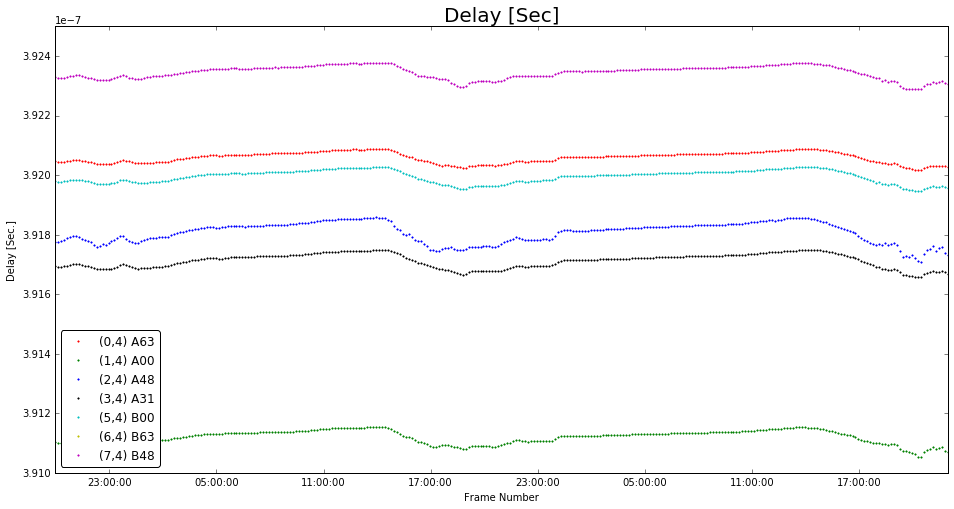

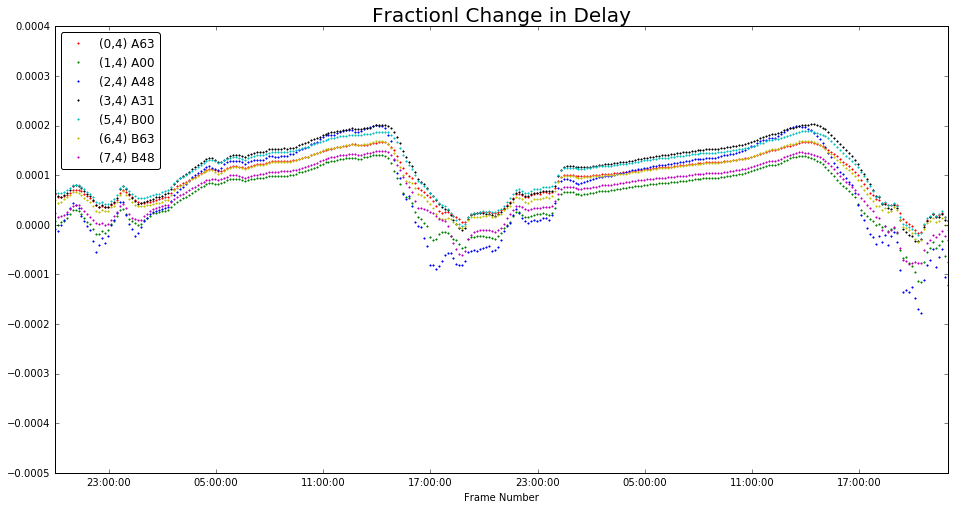

In [11]:
figure(figsize(16,8))
#plt.title('Delay [Sec.]', size=20)
plt.ylabel('Delay [Sec.]', size =10)
plt.xlabel('Frame Number', size=10)
k=1; dd=1; k=0

for i in range (len(corr_list)):  
    #print(i)
    plt.plot(date_stamp,delay[:,i], '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    plt.title('Delay [Sec]', size=20)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.xlim(date_stamp[0],date_stamp[300])
    plt.ylim(3.91*10**-7, 3.925*10**-7)
    k=k+1

figure(figsize(16,8))
k=0
for i in range (len(corr_list)): 
    #print(np.mean(delay[:,i]))
    plt.plot(date_stamp,(delay[:,i] - np.mean(delay[:,i]))/np.mean(delay[:,i]), '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    plt.title('Fractionl Change in Delay', size=20)
    plt.xlabel('Frame Number', size=10)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.xlim(date_stamp[0],date_stamp[300])
    k=k+1

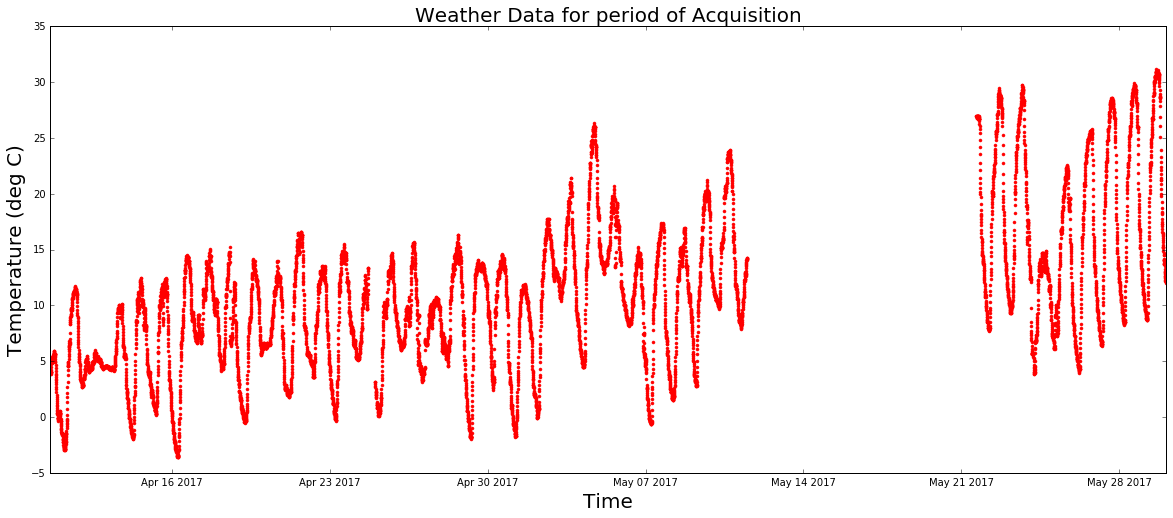

In [12]:
from IPython.display import Image
Image(filename='weather_data.png')

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


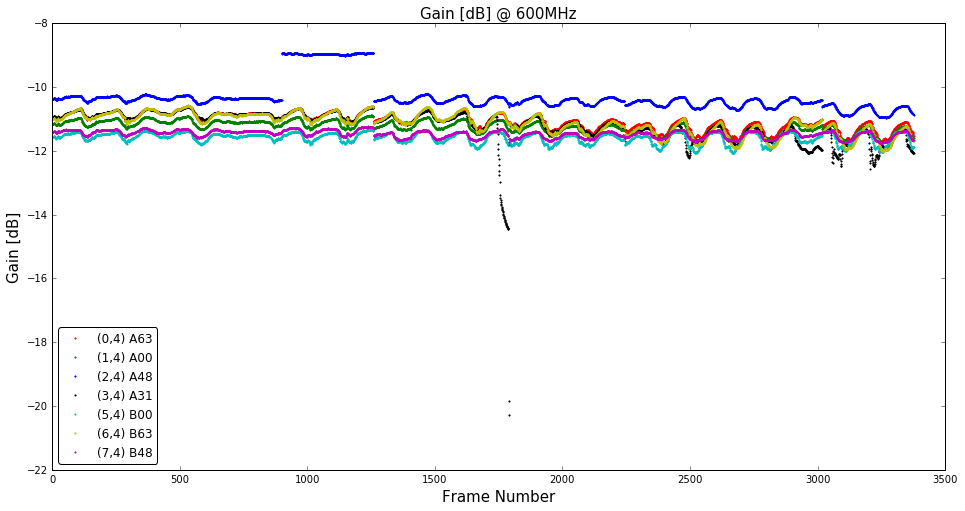

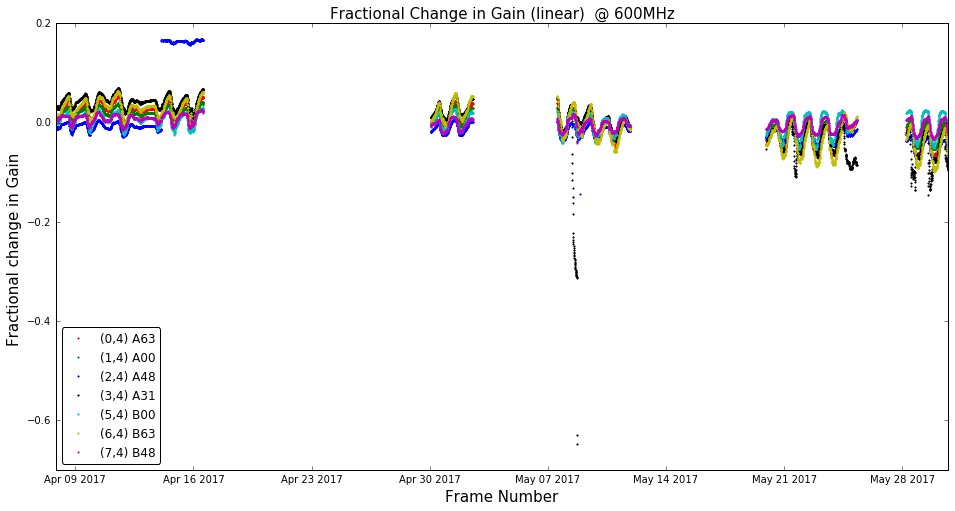

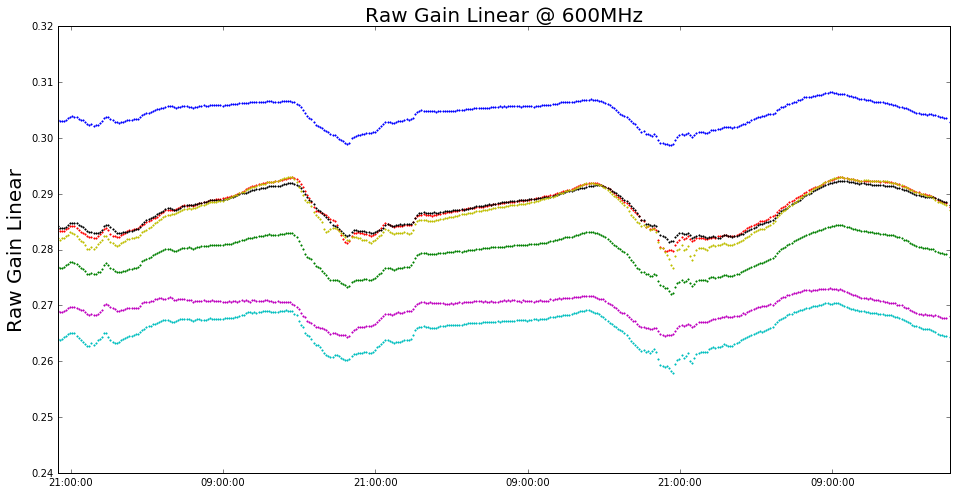

In [13]:
figure(figsize(16,8))
plt.title('Gain [dB] @ 600MHz', size=15)
plt.ylabel('Gain [dB]', size =15)
plt.xlabel('Frame Number', size=15)
dd=1; k=0
for i in range(len(corr_list)):
    plt.plot(gain_all_db[:,i,freq], '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    k=k+1

figure(figsize(16,8))
k=0
gain_all = 10**(gain_all_db/20)
for i in range(len(corr_list)):
    plt.plot(date_stamp,(gain_all[:,i,freq] - np.mean(gain_all[:,i,freq]))/np.mean(gain_all[:,i,freq]) , '.', color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.title('Fractional Change in Gain (linear)  @ 600MHz', size=15)
    plt.ylabel('Fractional change in Gain ', size =15)
    plt.xlabel('Frame Number', size=15)
    k=k+1

k=0
plt.figure()
for i in range(len(corr_list)):
    plt.plot(date_stamp,gain_all[:,i,freq],'.',color = colors[k] , markersize = 3)
    legend(loc='best', numpoints=1, fancybox=True)
    plt.title('Raw Gain Linear @ 600MHz', size=20)
    plt.ylabel('Raw Gain Linear', size =20)
    #plt.xlabel('Frame Number', size=20)
    plt.xlim(date_stamp[0],date_stamp[421])
    plt.ylim(0.24,0.32)
    
    
    k=k+1   

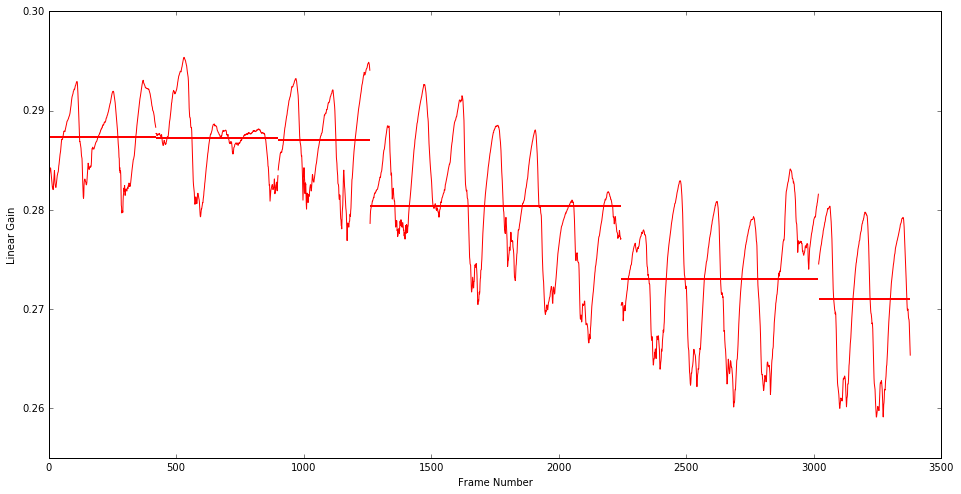

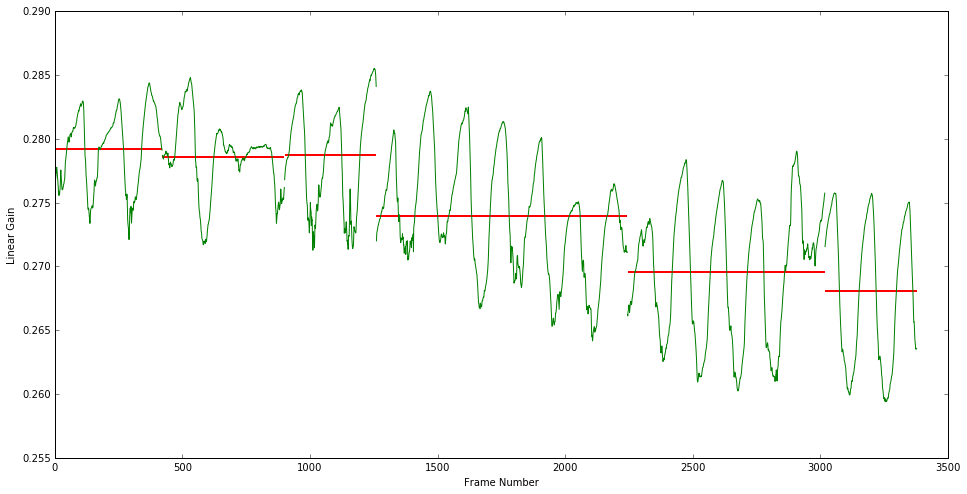

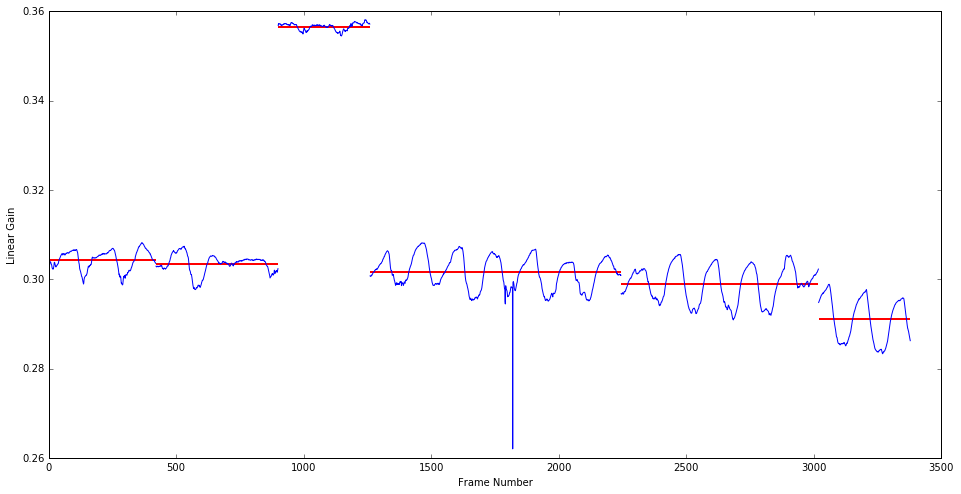

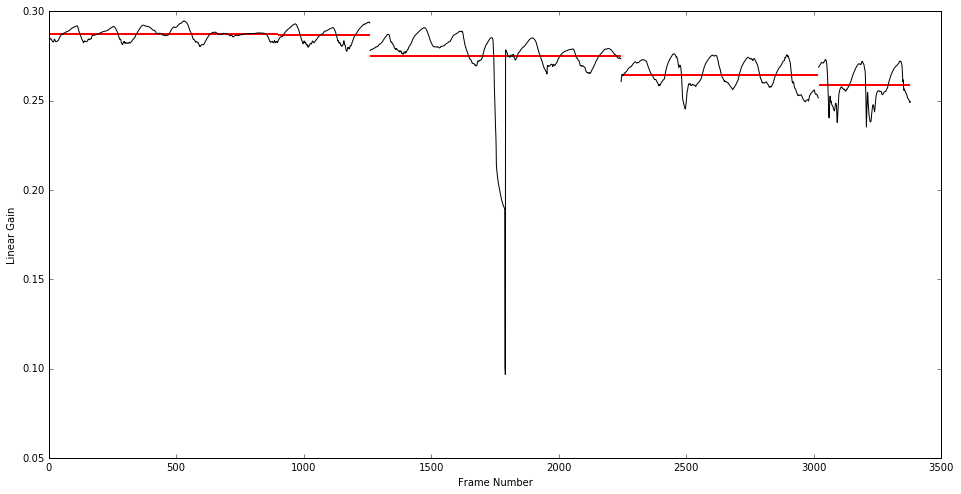

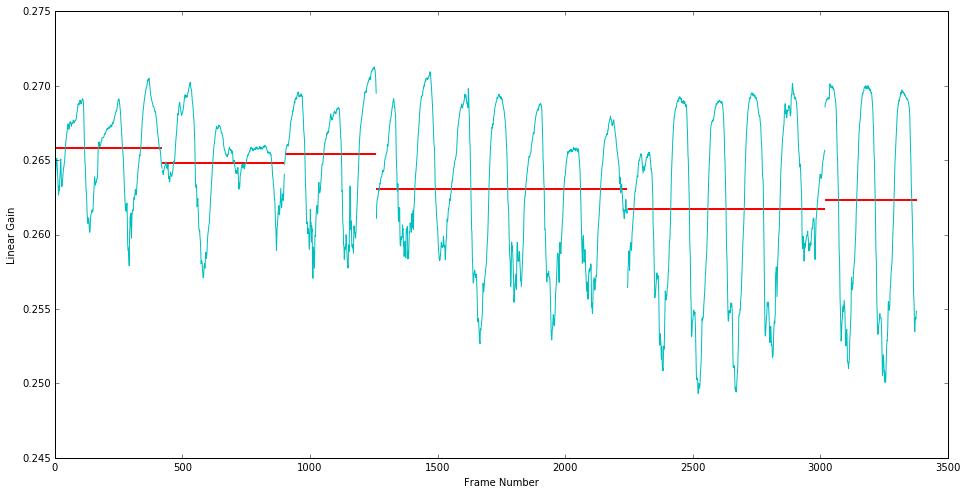

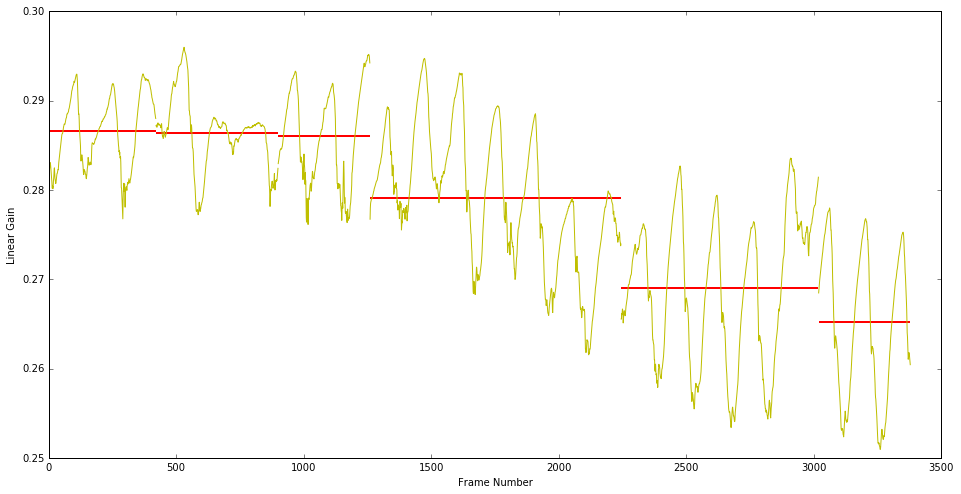

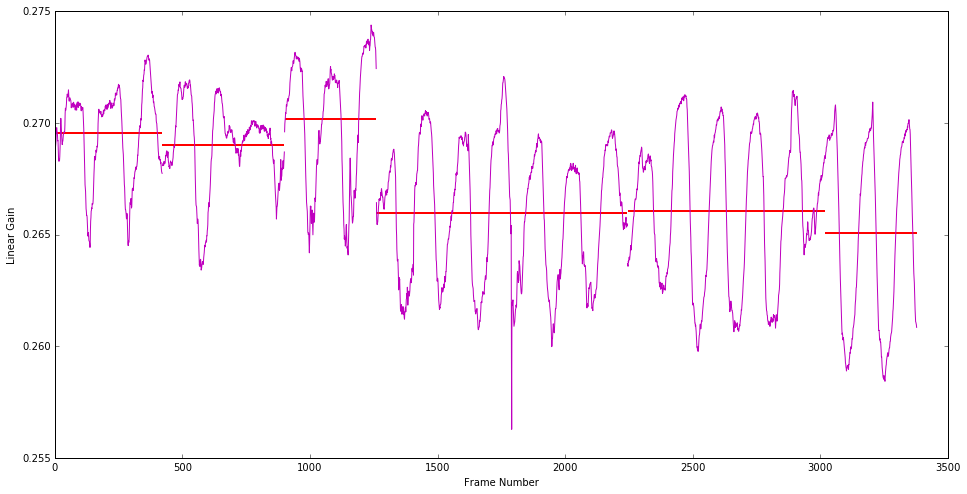

In [14]:
count_date=0
frame = np.linspace(0, len(gain_all[:,1,freq]), num=len(gain_all[:,1,freq]))
frame_per_dir = [421,479,360,984,774,360]
frame_seperate=[360,61,360,119,360,360,360,264,360,360,54,360]
date_time_all = []
for i in range(len(corr_list)):
    frame_count = 0
    for x in range(len(frame_per_dir)):
        time_stamp_sel= []
        time_stamp_temp = []
        #m = ((gain_all[frame_count:frame_count+frame_per_dir[x],i,freq] < np.mean(gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]) + 0.01) & (gain_all[frame_count:frame_count+frame_per_dir[x],i,freq] > np.mean(gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]) - 0.01) & (gain_all[frame_count:frame_count+frame_per_dir[x],i,freq] < np.mean(gain_all[:,i,freq])+0.05))
        plt.figure(i+1)
        #plt.plot(frame[m],gain_all[m,i,freq] ,'.' ,color = colors[k], label = str(legend_crosscorr[k]), markersize = 3)
        
        frame_sec = frame[frame_count:frame_count+frame_per_dir[x]]
        gain_sec = gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]
        time_stamp_temp = time_stamp[frame_count:frame_count+frame_per_dir[x]]
        time_stamp_sel = time_stamp_temp#[m]
        date_time = [datetime.datetime.fromtimestamp(time)+ datetime.timedelta(hours=7) for time in time_stamp_sel]
        plt.plot(frame_sec, gain_sec, color=colors[i], markersize=3)
        #plt.plot(frame_sec[m],gain_sec[m],color = colors[i], markersize = 3)
        #plt.plot( gain_sec[m],color = colors[i], markersize = 3)
        plt.ylabel('Linear Gain')
        plt.xlabel('Frame Number')
        
        if i==0:
            date_time_all.append(date_time)
        
        plt.hlines(y=np.mean(gain_all[frame_count:frame_count+frame_per_dir[x],i,freq]), xmin=frame[frame_count], xmax=frame[frame_count+frame_per_dir[x]-1], color='red', zorder=1, linewidth=2)
        #plt.hlines(y=np.mean(gain_sec[m]), xmin=frame[frame_count], xmax=frame[frame_count+frame_per_dir[x]-1], color='red', zorder=1, linewidth=2)
        
        frame_count = frame_count+frame_per_dir[x]
    '''
    k=0
    count=0
    
    for k in range(len(frame_seperate)):
        plt.axvline(x=count, linewidth=2, color='k')
        count = count+frame_seperate[k]
    plt.axhline(y=np.mean(gain_all[:,i,freq]),linewidth=3)
    '''


# in this we are taking all reflections of single day and then using it in all other days

In [15]:
date_stamp[422].minute

27

In [679]:
def find_nearest(array, value):
    n = [abs(i-value) for i in array]
    idx = n.index(min(n))
    return idx

In [680]:
count = 0
hours = np.linspace(0, 23, num=24)
minutes = np.linspace(0, 59, num=60)
data_reflection_all_cables=[]

for k in range(len(corr_list)):
    data_reflection_all_cables.append([])

for i in range(len(corr_list)):
    data_reflection = []
    count=0
    for j in range(3000):
        #print('frame #: %i, date: %i, month: %i, hour: %i, minute: %i' %(422+479+j, date_stamp[422+479+j].day,date_stamp[422+479+j].month,date_stamp[422+479+j].hour,date_stamp[422+479+j].minute ))
        if i==2:
            if date_stamp[j].day ==8:
                gain_line_sub=[]
                data_reflection.append([])

                z=np.polyfit(freq_phase[50:990], gain_all[j,i,:],1)
                p=np.poly1d(z)
                gain_line_sub = gain_all[j,i,:] - p(freq_phase[50:990])

                data_reflection[count].append(j)
                data_reflection[count].append(date_stamp[j].hour)
                data_reflection[count].append(date_stamp[j].minute)
                data_reflection[count].append(gain_all[j,i,:])
                data_reflection[count].append(gain_line_sub)
            
                count=count+1
        
        else:
            if date_stamp[j].day ==15:
                gain_line_sub=[]
                data_reflection.append([])

                z=np.polyfit(freq_phase[50:990], gain_all[j,i,:],1)
                p=np.poly1d(z)
                gain_line_sub = gain_all[j,i,:] - p(freq_phase[50:990])

                data_reflection[count].append(j)
                data_reflection[count].append(date_stamp[j].hour)
                data_reflection[count].append(date_stamp[j].minute)
                data_reflection[count].append(gain_all[j,i,:])
                data_reflection[count].append(gain_line_sub)

                count=count+1
    data_reflection_all_cables[i].append(data_reflection)
        
    #print ('%i,%i' %(422+j, date_stamp[422+j].hour))

In [681]:
print((data_reflection_all_cables[6][0][2]))

[1117, 0, 29, array([ 0.33577938,  0.33601724,  0.33491345,  0.3342784 ,  0.3349876 ,
        0.33643979,  0.33803106,  0.33856897,  0.33837075,  0.33835335,
        0.33781212,  0.33677983,  0.3366369 ,  0.33708051,  0.33722008,
        0.33715864,  0.33687958,  0.33544383,  0.33511308,  0.33481176,
        0.33379641,  0.33347227,  0.33396547,  0.33428712,  0.33491785,
        0.33587966,  0.33664904,  0.33787161,  0.33872483,  0.33760615,
        0.33588904,  0.33527396,  0.33531399,  0.33608872,  0.33724186,
        0.33696099,  0.33515067,  0.3333464 ,  0.3320546 ,  0.3322696 ,
        0.33461034,  0.33665942,  0.33645779,  0.3353424 ,  0.33498797,
        0.33618311,  0.33873401,  0.3406493 ,  0.34012984,  0.33767897,
        0.33534635,  0.33489252,  0.33665385,  0.33905481,  0.33947574,
        0.33703438,  0.33384616,  0.33282122,  0.33468418,  0.33783564,
        0.3399451 ,  0.33965734,  0.33787345,  0.33685084,  0.33773745,
        0.34025294,  0.34294791,  0.34344018,  0.3

In [682]:
#frame number(0), hour(1), minute(2), gain_all(3), Gain_lin_sub(4)
list2 = [item[4] for item in data_reflection_all_cables[1][0][:]]
print (len(list2[2]))


940


In [683]:
for i in range(len(corr_list)):
    list_min = [item[2] for item in data_reflection_all_cables[i][0][:]]
    print(list_min)

[9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59]
[9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29

In [684]:
for i in range(len(corr_list)):
    count=0
    for j in range(len(gain_all[:,i,freq])):
        z=np.polyfit(freq_phase[50:990], gain_all[j,i,:],1)
        p=np.poly1d(z)
        gain_line_sub = gain_all[j,i,:] - p(freq_phase[50:990])
        
        list_hr = [item[1] for item in data_reflection_all_cables[i][0][:]]

        index_hour = np.where(np.array(list_hr) == date_time[j].hour)[0] 
        
        list_min = [item[2] for item in data_reflection_all_cables[i][0][:]]
        index_minute = find_nearest(np.array(list_min), date_time[j].minute)
        
        x = np.intersect1d(index_hour,index_minute)
        
        aa=[1,2,3,4,5,6,7,8,9]
        '''
        if j in aa:
            print(index_hour)
            print(index_minute)
        '''    
        if len(x)!= 1:
            count=count+1
            
    #print(count)

IndexError: list index out of range

In [685]:
#print(list_min)
print(list_hr)
print(list_min)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23]
[9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59, 9, 19, 29, 39, 49, 59,

In [686]:
#for i in range(len(corr_list)):
 
for j in range(len(gain_all[:,1,freq])):
    hour_now = date_stamp[j].hour
    minute_now = date_stamp[j].minute
    
    hour_index = np.where(np.array(list_hr) == hour_now)
    min_find=  np.array(hour_index)[0]
    minute_index_pre = find_nearest( np.array(list_min)[min_find], minute_now)
    minute_index = min_find[minute_index_pre]

    final_position_pre = np.intersect1d(min_find,minute_index)
    final_position = final_position_pre[0]

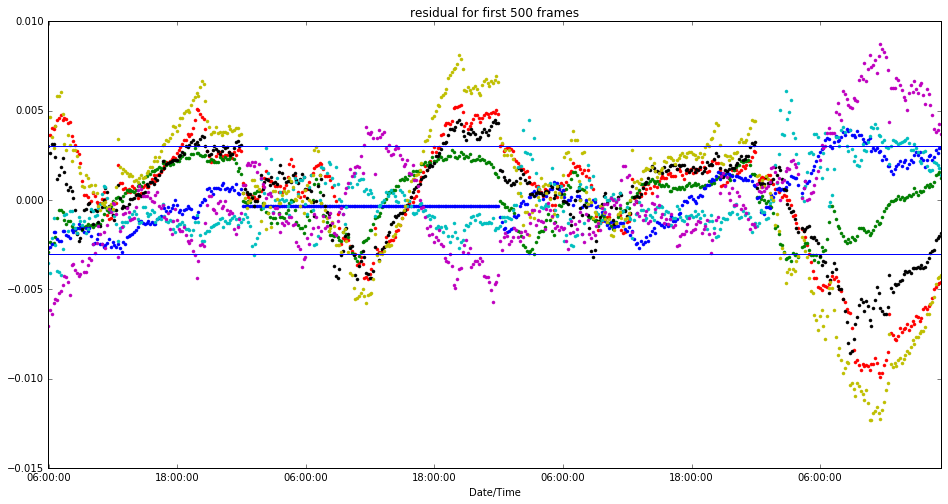

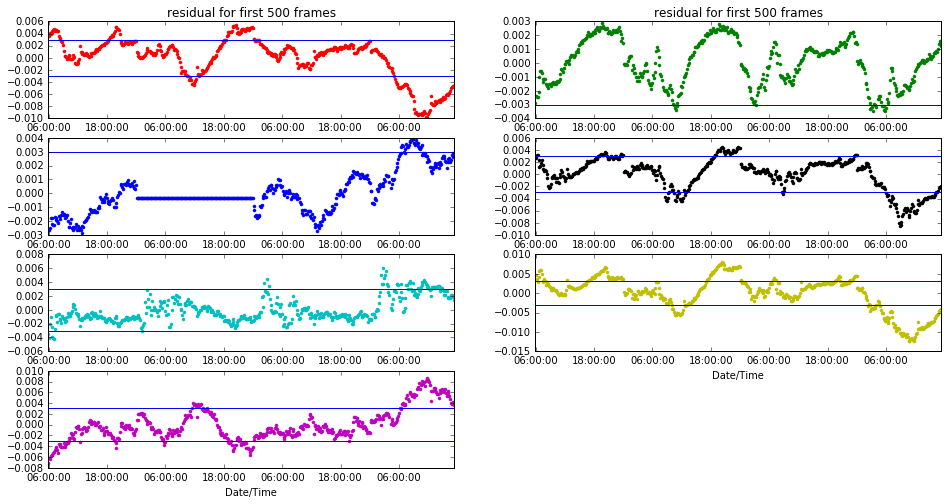

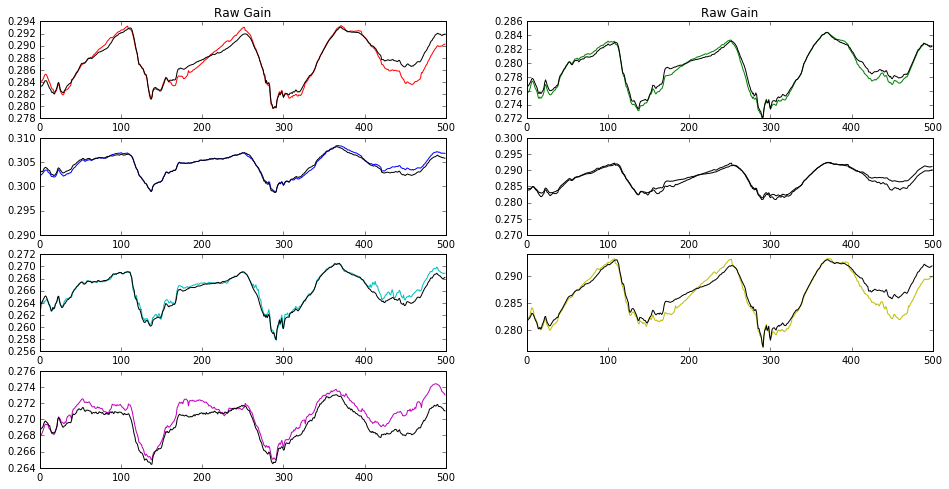

In [689]:

for i in range(len(corr_list)):
    reflections_all_time = [item[4] for item in data_reflection_all_cables[i][0][:]]
    gain_per_frame_600 = np.zeros(len(gain_all[:,1,1]))
    #for j in range(500):
    for j in range(len(gain_all[:,1,freq])):
        hour_now = date_stamp[j].hour
        minute_now = date_stamp[j].minute

        hour_index = np.where(np.array(list_hr) == hour_now)
        min_find=  np.array(hour_index)[0]
        minute_index_pre = find_nearest( np.array(list_min)[min_find], minute_now)
        minute_index = min_find[minute_index_pre]

        final_position_pre = np.intersect1d(min_find,minute_index)
        final_position = final_position_pre[0]

        z=np.polyfit(freq_phase[50:990], gain_all[j,i,:],1)
        p=np.poly1d(z)
        gain_per_frame = p(freq_phase[50:990]) + reflections_all_time[final_position]
        gain_per_frame_600[j] = gain_per_frame[freq]
 
    #plt.figure(i+1)
    #plt.plot(gain_per_frame_600)
    #plt.plot(gain_all[:,i,freq])
    lim=500
    plt.figure(1)
    model_frac_change_gain = (gain_per_frame_600[0:lim]-np.mean(gain_per_frame_600[0:lim]))/np.mean(gain_per_frame_600[0:lim])
    raw_frac_change_gain = (gain_all[0:lim,i,freq]-np.mean(gain_all[0:lim,i,freq]))/np.mean(gain_all[0:lim,i,freq])
    plt.plot(date_stamp[0:lim],model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
    plt.title('residual for first 500 frames')
    plt.xlabel('Date/Time')
    plt.axhline(y = 0.003 )
    plt.axhline(y = -0.003 )
    #plt.plot(temp_need)
    
    plt.figure(2)
    plt.subplot(4,2,i+1)
    lim2 = 2000
    if i==0 or i==1:
        plt.title('residual for first 500 frames')
    plt.plot(date_stamp[0:lim],model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
    
    plt.xlabel('Date/Time')
    plt.axhline(y = 0.003 )
    plt.axhline(y = -0.003 )
    
    
    plt.figure(3)
    plt.subplot(4,2,i+1)
    lim2 = 500
    if i==0 or i==1:
        plt.title('Raw Gain')
    plt.plot(gain_per_frame_600[0:lim], color = colors[i])
    if i==2 :
        plt.ylim(0.29,0.31)
    if i==3:
        plt.ylim(0.27,0.30)
    plt.plot(gain_all[0:lim2,i,freq], 'k')


# In earlier plot, we were modeling reflection for one day and using it for other days for 500 frames, now we are doing it for all frames

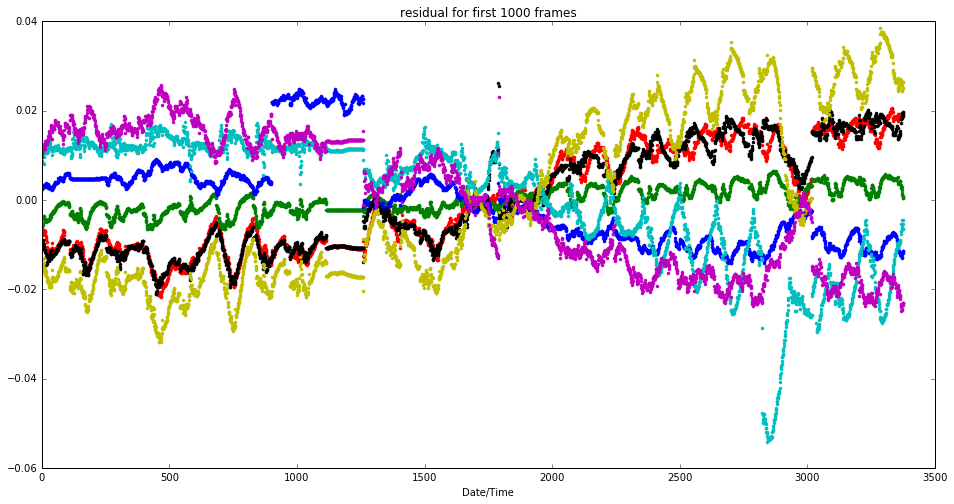

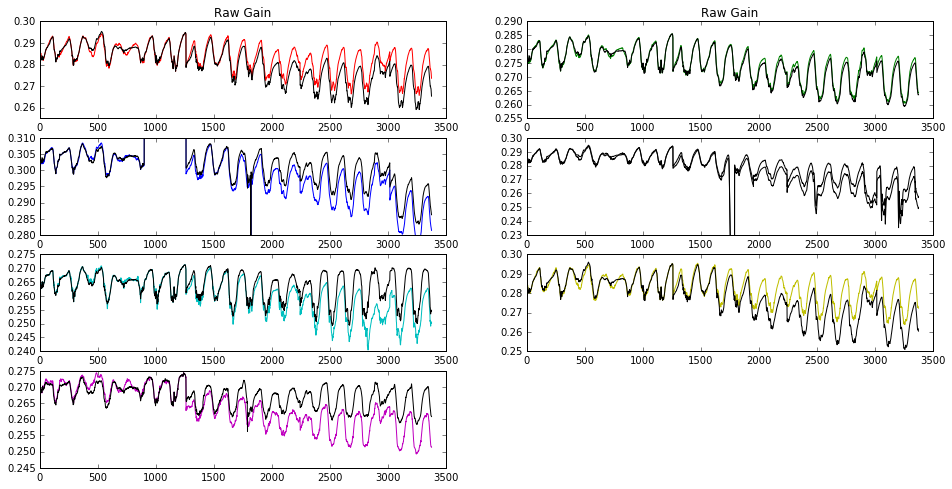

In [691]:
for i in range(len(corr_list)):
    reflections_all_time = [item[4] for item in data_reflection_all_cables[i][0][:]]
    gain_per_frame_600 = np.zeros(len(gain_all[:,1,1]))
    #for j in range(500):
    for j in range(len(gain_all[:,1,freq])):
        hour_now = date_stamp[j].hour
        minute_now = date_stamp[j].minute

        hour_index = np.where(np.array(list_hr) == hour_now)
        min_find=  np.array(hour_index)[0]
        minute_index_pre = find_nearest( np.array(list_min)[min_find], minute_now)
        minute_index = min_find[minute_index_pre]

        final_position_pre = np.intersect1d(min_find,minute_index)
        final_position = final_position_pre[0]

        z=np.polyfit(freq_phase[50:990], gain_all[j,i,:],1)
        p=np.poly1d(z)
        gain_per_frame = p(freq_phase[50:990]) + reflections_all_time[final_position]
        gain_per_frame_600[j] = gain_per_frame[freq]
 
    plt.figure(1)
    model_frac_change_gain = (gain_per_frame_600-np.mean(gain_per_frame_600))/np.mean(gain_per_frame_600)
    raw_frac_change_gain = (gain_all[:,i,freq]-np.mean(gain_all[:,i,freq]))/np.mean(gain_all[:,i,freq])
    plt.plot(model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
    if i==0 or i==1:
        plt.title('residual for first 1000 frames')
    plt.xlabel('Date/Time')
    
    '''
    plt.figure(2)
    plt.subplot(4,2,i+1)
    if i==0 or i==1:
        plt.title('residual for first 1000 frames')
    plt.plot(model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
    
    plt.xlabel('Date/Time')
    #plt.axhline(y = 0.003 )
    #plt.axhline(y = -0.003 )
    '''
    
    plt.figure(3)
    plt.subplot(4,2,i+1)

    if i==0 or i==1:
        plt.title('Raw Gain')
    plt.plot(gain_per_frame_600, color = colors[i])
    if i==2 :
        plt.ylim(0.28,0.31)
    if i==3:
        plt.ylim(0.23,0.30)
    plt.plot(gain_all[:,i,freq], 'k')

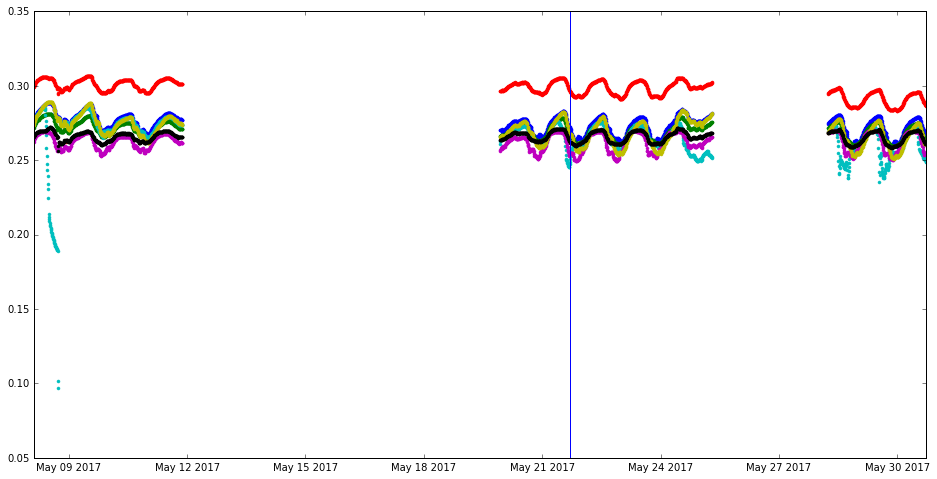

In [171]:
for i in range(len(corr_list)):
    plt.figure(1)
    plt.plot(date_stamp[1700:len(date_stamp)], gain_all[1700:len(date_stamp),i,freq], '.')
    plt.axvline(date_stamp[2500])

# this time we are taking all reflections for a day in single acquisition and using it for other days in that acquisition. 
# NOTE: At this point, we are not modelling reflections, we are copying all the reflections for single day.

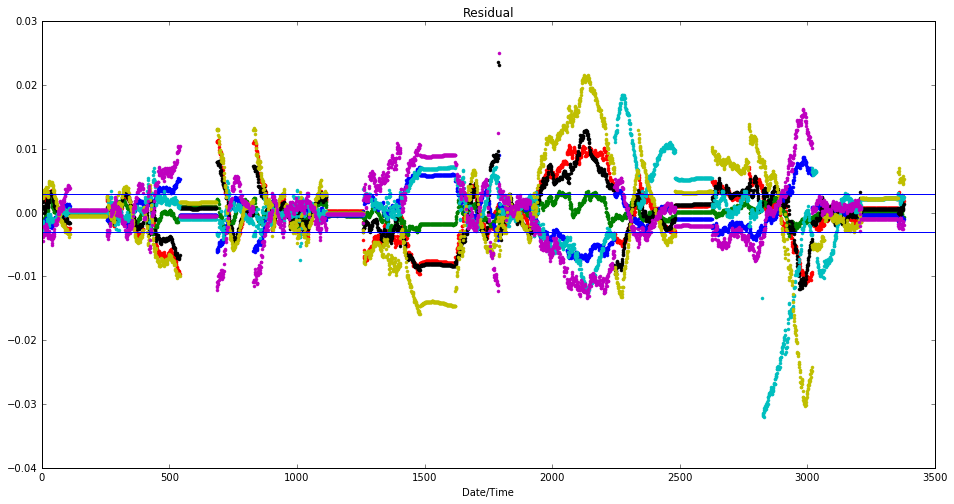

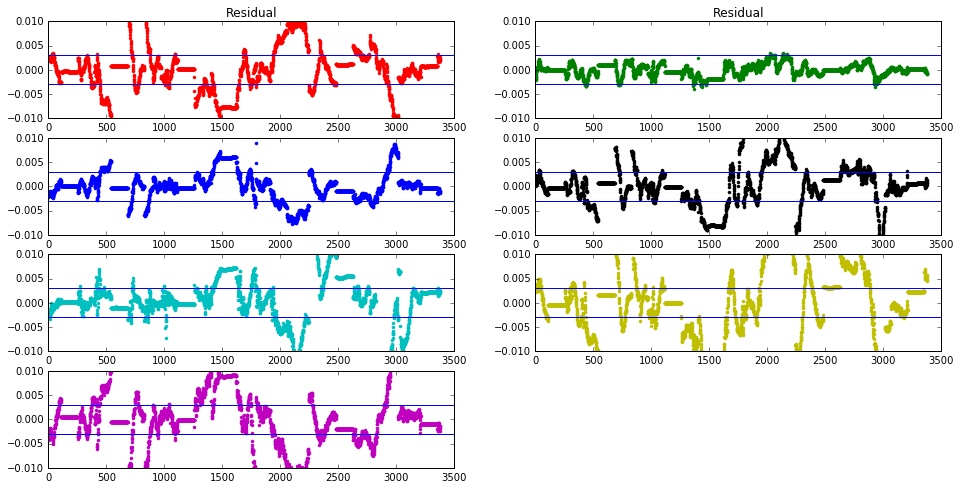

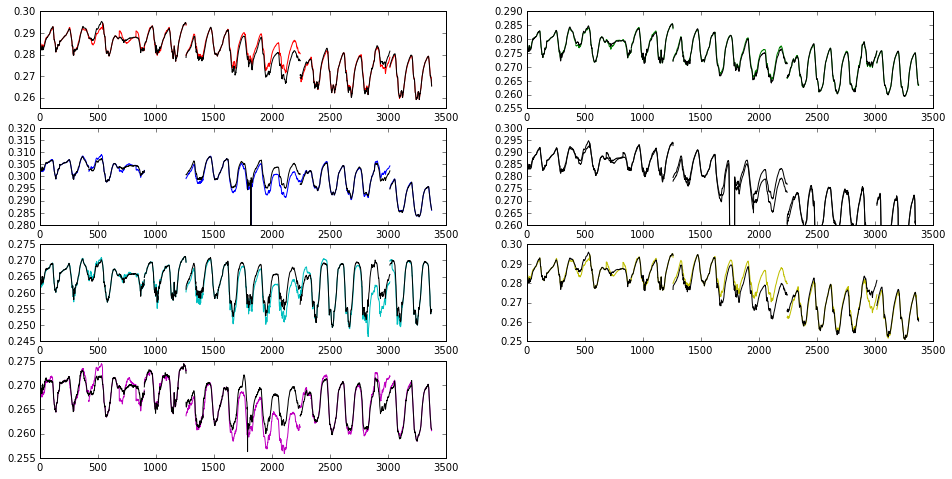

In [702]:
count = 0
hours = np.linspace(0, 23, num=24)
minutes = np.linspace(0, 59, num=60)
data_reflection_all_cables=[]

date_for_selection= [8,11,15,1,21,29]

for kkk in range(len(corr_list)):
    data_reflection_all_cables.append([])

# i: corr_list, k: frames_per directory , j: # of frames in that partular length of frames

for i in range(len(corr_list)):
    count_all = 0
    count_new = 0
    count_plot = 0

    for k in range(len(frame_per_dir)):
        count=0 # for incrimental of data_reflection 
        data_reflection = []
        #print(len(data_reflection))
        for j in range(frame_per_dir[k]):
            #print(' Val j %i' %(j))
            #print('now %i, what we want %i, val k %i' %(date_stamp[count_all].day,date_for_selection[k], k))
            if date_stamp[count_all].day == date_for_selection[k]:
                #print('val of cable %i, val of count_all %i, date %i' %(i,count_all,date_for_selection[k]))
                 
                gain_line_sub=[]
                data_reflection.append([])

                z=np.polyfit(freq_phase[50:990], gain_all[count_all,i,:],1)
                p=np.poly1d(z)
                gain_line_sub = gain_all[count_all,i,:] - p(freq_phase[50:990])

                data_reflection[count].append(count_all)
                data_reflection[count].append(date_stamp[count_all].hour)
                data_reflection[count].append(date_stamp[count_all].minute)
                data_reflection[count].append(gain_all[count_all,i,:])
                data_reflection[count].append(gain_line_sub)

                count = count + 1
            count_all = count_all + 1

        
        reflections_all_time = []
        reflections_all_time = [item[4] for item in data_reflection[:]]
        list_hr = [item[1] for item in data_reflection[:]]
        list_min = [item[2] for item in data_reflection[:]]
        
        #if i==0 or i==1:
        #    plt.figure(2)
        #    plt.subplot(4,2,k+1)
        #    plt.plot(reflections_all_time[3], color = colors[i])
        
        gain_per_frame_600 = np.zeros(frame_per_dir[k])

        for kk in range(frame_per_dir[k]):

            hour_now = date_stamp[count_new].hour # hour for particular frame
            minute_now = date_stamp[count_new].minute # minute for particular frame
            
            hour_index = np.where(np.array(list_hr) == hour_now) # finding index, where hour of reflection anf hr of this frame matches
            min_find=  np.array(hour_index)[0]
            minute_index_pre = find_nearest(np.array(list_min)[min_find], minute_now)
            minute_index = min_find[minute_index_pre]

            final_position_pre = np.intersect1d(min_find,minute_index) 
            final_position = final_position_pre[0] 
            
            z=np.polyfit(freq_phase[50:990], gain_all[count_new,i,:],1)
            p=np.poly1d(z)
            gain_per_frame = p(freq_phase[50:990]) + reflections_all_time[final_position]
            gain_per_frame_600[kk] = gain_per_frame[freq]

            count_new = count_new + 1
                                
        
        plt.figure(1)
        model_frac_change_gain = (gain_per_frame_600-np.mean(gain_per_frame_600))/np.mean(gain_per_frame_600)
        raw_frac_change_gain = (gain_all[count_new - frame_per_dir[k] :count_new,i,freq]-np.mean(gain_all[count_new - frame_per_dir[k] :count_new,i,freq]))/np.mean(gain_all[count_new - frame_per_dir[k] :count_new,i,freq])
        plt.plot(np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]), model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
        plt.title('Residual', size =15)
        plt.xlabel('Date/Time', size =15)
        plt.axhline(y = 0.003 )
        plt.axhline(y = -0.003 )


        plt.figure(2)
        plt.subplot(4,2,i+1)
        plt.plot(np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]), model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
        if i==0 or i==1:
            plt.title('Residual')
        plt.axhline(y = 0.003 )
        plt.axhline(y = -0.003 )
        plt.ylim(-0.01,0.01)
        
        plt.figure(3)
        plt.subplot(4,2,i+1)
        if i==2: 
            plt.ylim(0.28,0.32)
        if i==3:
            plt.ylim(0.26,0.30)
        #plt.plot( date_stamp[count_new - frame_per_dir[k]:count_new],gain_per_frame_600,  '.',color = colors[i])
        #plt.plot(date_stamp[count_new - frame_per_dir[k]:count_new],gain_all[count_new - frame_per_dir[k] :count_new,i,freq], 'k')
        plt.plot( np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]),gain_per_frame_600,  color = colors[i])
        plt.plot(np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]),gain_all[count_new - frame_per_dir[k] :count_new,i,freq], 'k')
        #plt.xlim(1260,2250)

In [209]:
print(data_reflection[46][1])
print(data_reflection[46][2])
print(hour_now)
print('')
print(hour_index)
print(min_find)
print(minute_index)
print(final_position_pre)
print(final_position)
print(date_stamp[len(date_stamp)-1])

7
40
7

(array([42, 43, 44, 45, 46, 47], dtype=int64),)
[42 43 44 45 46 47]
46
[46]
46
2017-05-30 17:40:07


# This time we are modelling reflections for a day in single acquisition and using it for other days in that acquisition . 

In [706]:
# returning gian_sub, reflection components index number, 
def reflection_comp(gain_part):
    components_all_cables=[]
    amplitude_all_cables=[]
    gain_all_line_sub=[]
    
    components=[]
    amplitude =[]
    
    z=np.polyfit(freq_phase[50:990], gain_part,1)
    p=np.poly1d(z)
    gain_line_sub = gain_part - p(freq_phase[50:990])
    
    gain_all_line_sub.append(gain_line_sub)
    
    ifft_component = np.fft.ifft(gain_line_sub) 
    ifft_component1 = np.fft.ifft(gain_line_sub) 
    ifft_component0 = np.fft.ifft(gain_line_sub) 
    
    end = len(ifft_component)

    for i in range(end):
        if np.abs(ifft_component[i]) > np.mean(np.abs(ifft_component)):#-np.mean(np.abs(ifft_component))/2:
            components.append(i)
            amplitude.append(np.abs(ifft_component[i]))
    
    end_components = len(components)
    ifft_component1[components] = ifft_component1[33]

    for i in range(len(ifft_component)):
        if i  not in components: 
            ifft_component0[i] = 0
    return components, gain_line_sub , p(freq_phase[50:990])
      

In [230]:
def my_sin(term2,amp,phase,n):
    return amp*np.sin(n*term2 + phase)

Cable Number 0 and directory number 0
Cable Number 0 and directory number 1
Cable Number 0 and directory number 2
Cable Number 0 and directory number 3
Cable Number 0 and directory number 4
Cable Number 0 and directory number 5
Cable Number 1 and directory number 0
Cable Number 1 and directory number 1
Cable Number 1 and directory number 2
Cable Number 1 and directory number 3
Cable Number 1 and directory number 4
Cable Number 1 and directory number 5
Cable Number 2 and directory number 0
Cable Number 2 and directory number 1
Cable Number 2 and directory number 2
Cable Number 2 and directory number 3
Cable Number 2 and directory number 4
Cable Number 2 and directory number 5
Cable Number 3 and directory number 0
Cable Number 3 and directory number 1
Cable Number 3 and directory number 2
Cable Number 3 and directory number 3
Cable Number 3 and directory number 4
Cable Number 3 and directory number 5
Cable Number 4 and directory number 0
Cable Number 4 and directory number 1
Cable Number

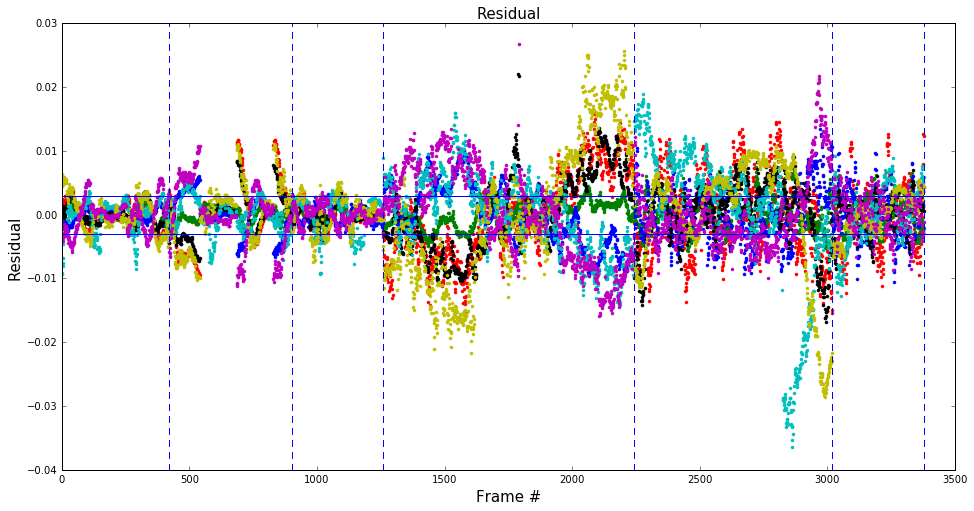

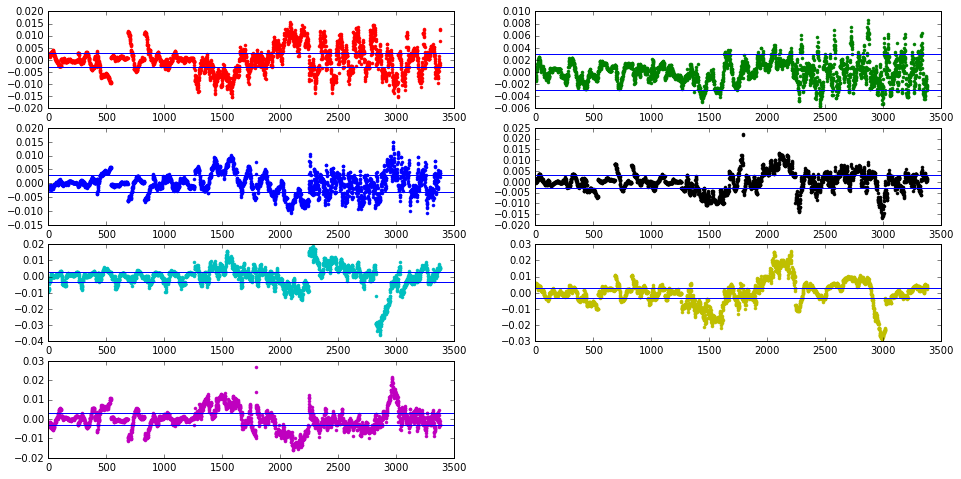

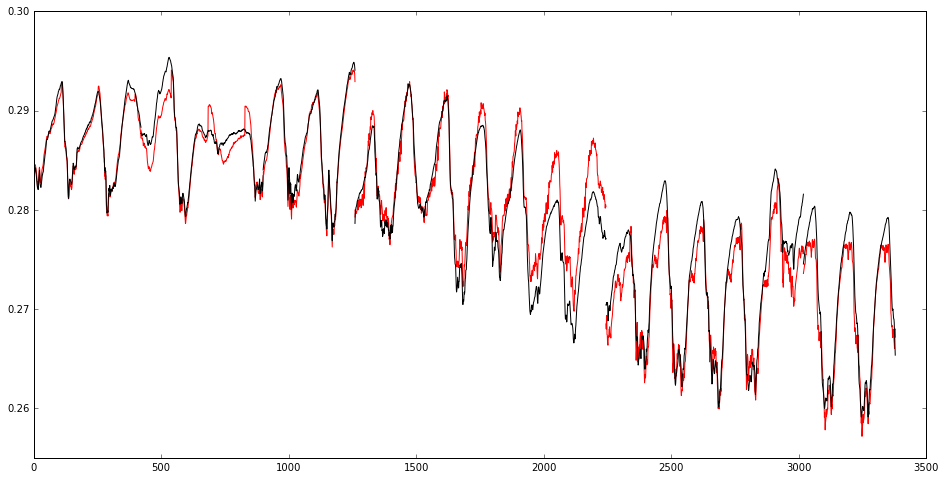

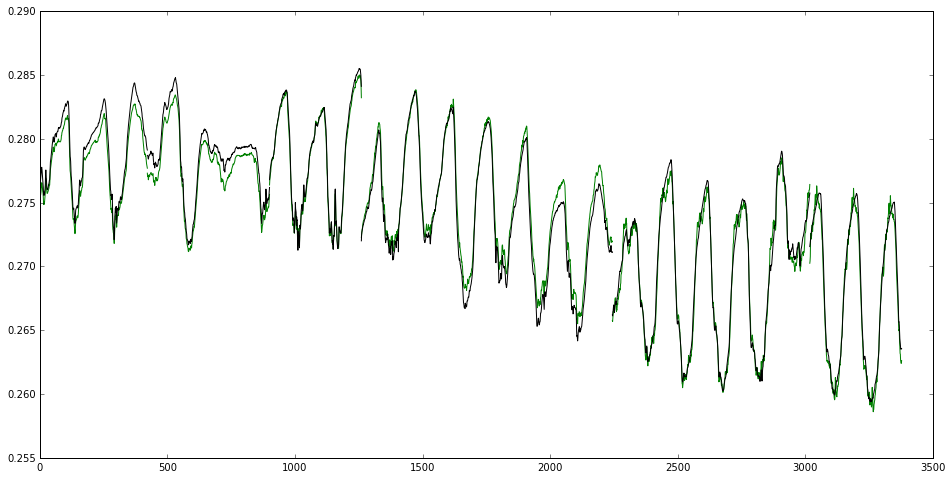

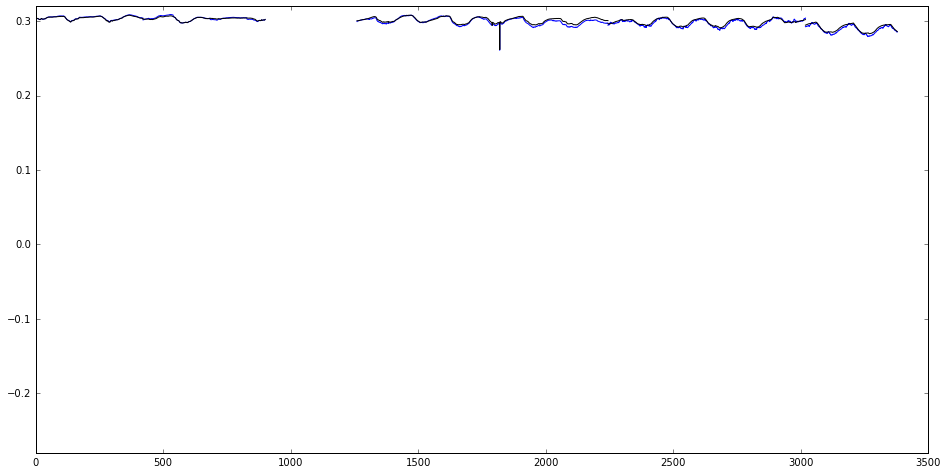

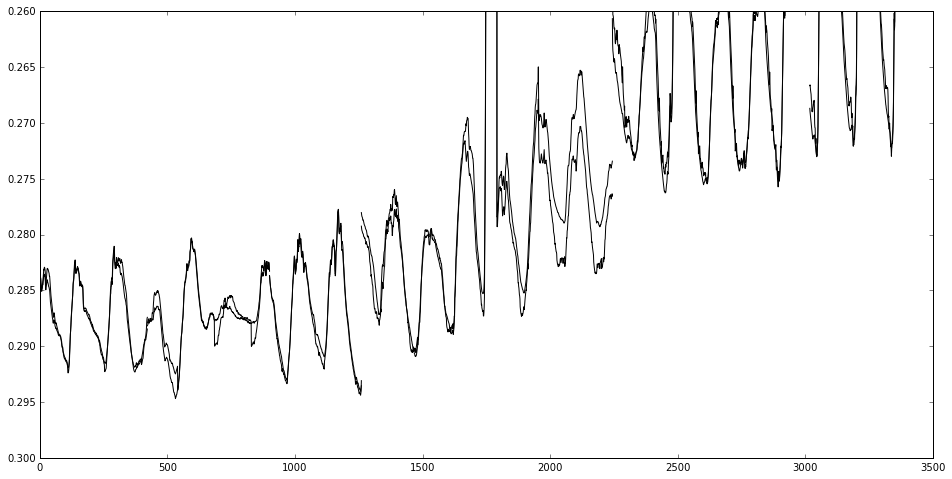

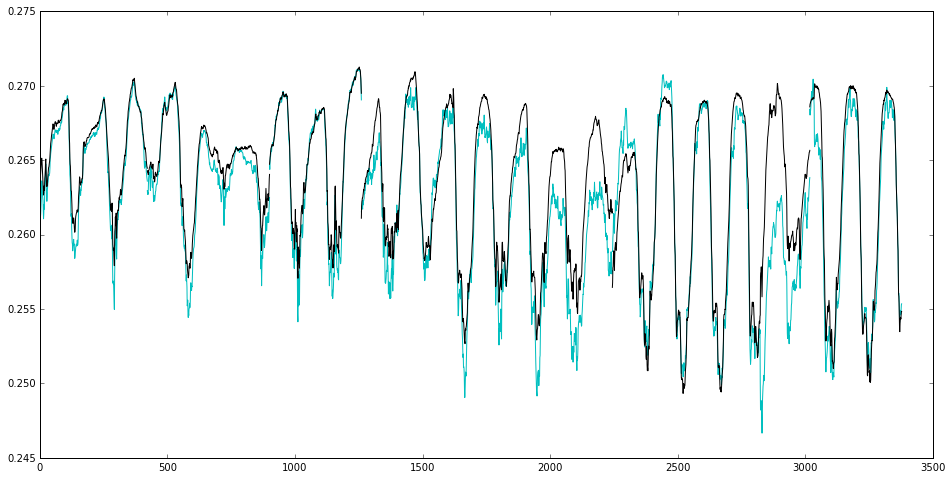

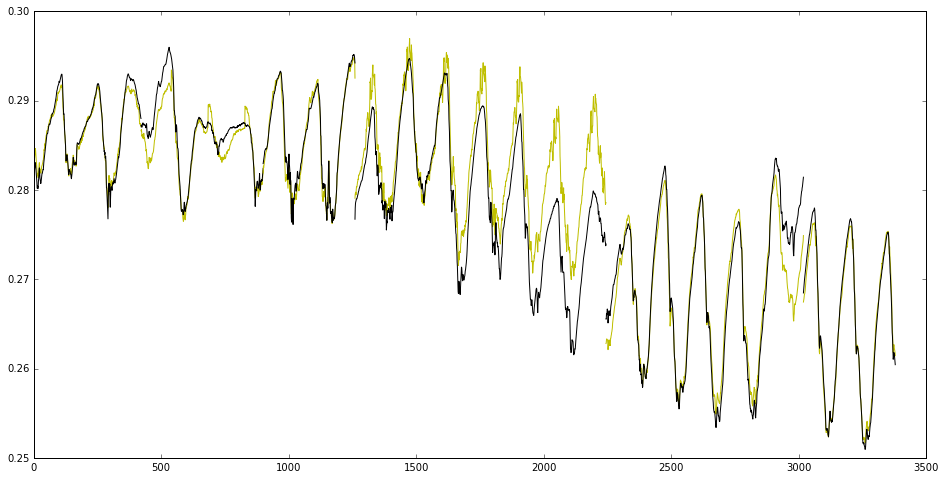

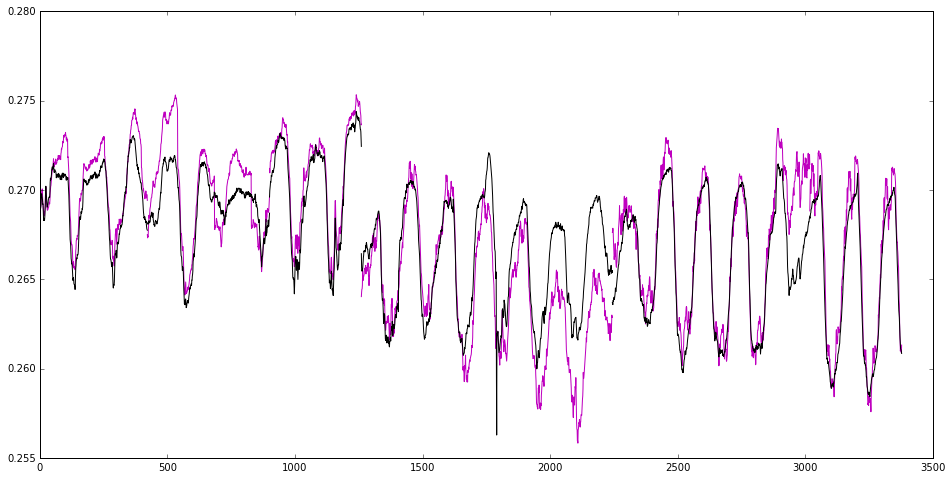

In [707]:
N= len(freq_phase[50:990])
term2 = np.arange(N) 
count = 0
hours = np.linspace(0, 23, num=24)
minutes = np.linspace(0, 59, num=60)
data_reflection_all_cables=[]

date_for_selection= [8,11,15,1,21,29]

for kkk in range(len(corr_list)):
    data_reflection_all_cables.append([])

# i: corr_list, k: frames_per directory , j: # of frames in that partular length of frames

for i in range(len(corr_list)):
    
    count_all = 0
    count_new = 0
    count_plot = 0
    reflection_components=[]
    
    for k in range(len(frame_per_dir)):
        print('Cable Number %i and directory number %i' %(i,k))
        count=0 # for incrimental of data_reflection 
        data_reflection = []
        
        
        for j in range(frame_per_dir[k]):
            #print(' Val j %i' %(j))
            #print('now %i, what we want %i, val k %i' %(date_stamp[count_all].day,date_for_selection[k], k))
            
            if date_stamp[count_all].day == date_for_selection[k]:
                #print('val of cable %i, val of count_all %i, date %i' %(i,count_all,date_for_selection[k]))
                reflections_generate_part_one_cable = np.zeros(940)
                gain_line_sub=[]
                data_reflection.append([])
                
                ref_terms, gain_line_sub, lin_line_part = reflection_comp(gain_all[count_all,i,:])

                data_reflection[count].append(count_all)
                data_reflection[count].append(date_stamp[count_all].hour)
                data_reflection[count].append(date_stamp[count_all].minute)
                data_reflection[count].append(gain_all[count_all,i,:])
                
                # want to add new/modeled reflection  
                
                for ii in range(len(ref_terms)):
                    ifft_reflection_part = np.fft.ifft(gain_line_sub)

                    for kk in range(len(ifft_reflection_part)):
                        if kk != ref_terms[ii]:
                            ifft_reflection_part[kk]=0

                    ifft_reflections_real = np.real(np.fft.fft(ifft_reflection_part))

                    guess_amplitude = np.max(ifft_reflections_real)
                    guess_phase = 0.75 #1.5 
                    n=2*np.pi*ref_terms[ii]/940

                    if ii==2:
                        guess_phase = 1.5
                    if ii==9:
                        guess_phase = np.pi

                    guess_offset = np.mean(ifft_reflections_real) 
                    p0=[ guess_amplitude, guess_phase, n]

                    fit = curve_fit(my_sin, term2, ifft_reflections_real, p0=p0)
                    data_fit = my_sin(term2, *fit[0])

                    fit_leastsq = leastsq(lambda p: my_sin(term2, *p) - ifft_reflections_real, p0)
                    reflections_generate_part_one_cable = reflections_generate_part_one_cable + data_fit
                
                data_reflection[count].append(reflections_generate_part_one_cable)
                data_reflection[count].append(gain_line_sub)
                count = count + 1   
            count_all = count_all + 1

        reflections_all_time = []
        reflections_all_time = [item[4] for item in data_reflection[:]]
        list_hr = [item[1] for item in data_reflection[:]]
        list_min = [item[2] for item in data_reflection[:]]
        
        #if i==0 or i==1:
        #    plt.figure(2)
        #    plt.subplot(4,2,k+1)
        #    plt.plot(reflections_all_time[3], color = colors[i])
        
        gain_per_frame_600 = np.zeros(frame_per_dir[k])

        for kk in range(frame_per_dir[k]):

            hour_now = date_stamp[count_new].hour # hour for particular frame
            minute_now = date_stamp[count_new].minute # minute for particular frame
            
            hour_index = np.where(np.array(list_hr) == hour_now) # finding index, where hour of reflection anf hr of this frame matches
            min_find=  np.array(hour_index)[0]
            minute_index_pre = find_nearest(np.array(list_min)[min_find], minute_now)
            minute_index = min_find[minute_index_pre]

            final_position_pre = np.intersect1d(min_find,minute_index) 
            final_position = final_position_pre[0] 
            
            z=np.polyfit(freq_phase[50:990], gain_all[count_new,i,:],1)
            p=np.poly1d(z)
            gain_per_frame = p(freq_phase[50:990]) + reflections_all_time[final_position]
            gain_per_frame_600[kk] = gain_per_frame[freq]

            count_new = count_new + 1
                                
        
        plt.figure(1)
        model_frac_change_gain = (gain_per_frame_600-np.mean(gain_per_frame_600))/np.mean(gain_per_frame_600)
        raw_frac_change_gain = (gain_all[count_new - frame_per_dir[k] :count_new,i,freq]-np.mean(gain_all[count_new - frame_per_dir[k] :count_new,i,freq]))/np.mean(gain_all[count_new - frame_per_dir[k] :count_new,i,freq])
        plt.plot(np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]), model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
        plt.title('Residual', size =15)
        plt.xlabel('Frame #', size =15)
        plt.ylabel('Residual', size = 15)
        plt.axhline(y = 0.003 )
        plt.axhline(y = -0.003 )
        plt.axvline(x = count_new, linestyle = '--')

        plt.figure(2)
        plt.subplot(4,2,i+1)
        plt.plot(np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]), model_frac_change_gain - raw_frac_change_gain, '.', color=colors[i])
        plt.axhline(y = 0.003 )
        plt.axhline(y = -0.003 )
        
        plt.figure(3+i)
        
        if i==2:
            plt.ylim(-.28,0.32)
        if i==3:
            plt.ylim(0.30,0.26)
        #plt.subplot(4,2,i+1)
        #plt.plot( date_stamp[count_new - frame_per_dir[k]:count_new],gain_per_frame_600,  '.',color = colors[i])
        #plt.plot(date_stamp[count_new - frame_per_dir[k]:count_new],gain_all[count_new - frame_per_dir[k] :count_new,i,freq], 'k')
        plt.plot( np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]),gain_per_frame_600,  color = colors[i])
        plt.plot(np.linspace(count_new - frame_per_dir[k],count_new, num =frame_per_dir[k]),gain_all[count_new - frame_per_dir[k] :count_new,i,freq], 'k')

In [233]:
print(reflection_components)

[]


421
421
900
479
1260
360
2244
984
3018
774
3378
360


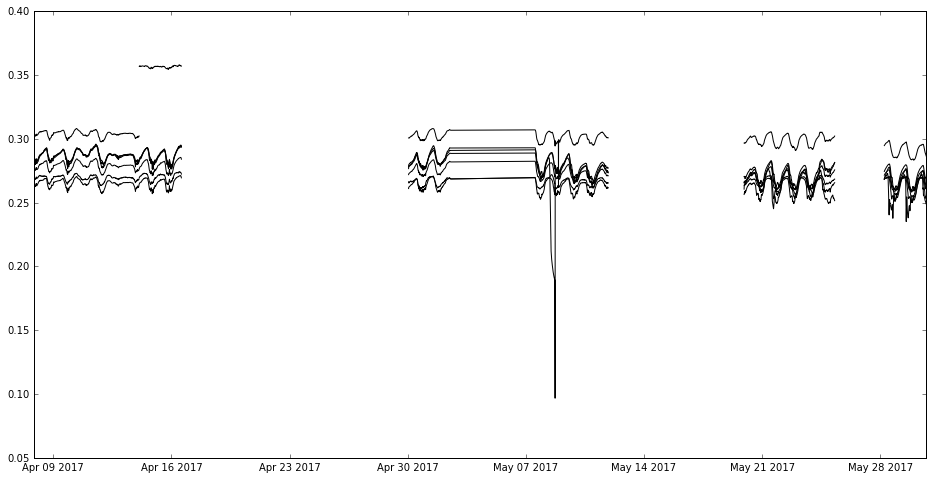

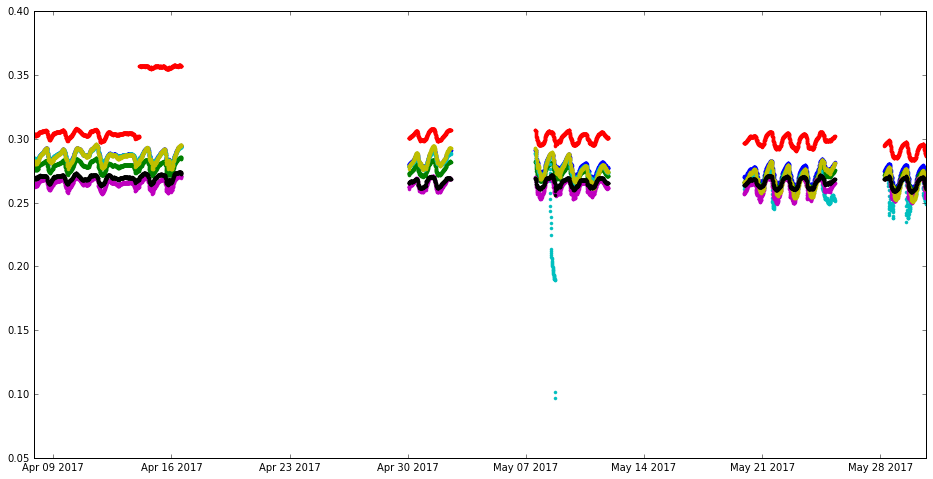

In [187]:
for i in range(len(corr_list)):
    count_new=0
    for j in range(len(frame_per_dir)):
        plt.figure(1)
        plt.plot(date_stamp[count_new:count_new + frame_per_dir[j]],gain_all[count_new :count_new + frame_per_dir[j],i,freq], 'k')
        count_new = count_new+frame_per_dir[j]
        
        if i==0:
            print(count_new)
            print(frame_per_dir[j])
            
    plt.figure(2)
    plt.plot(date_stamp, gain_all[:,i,freq],'.')

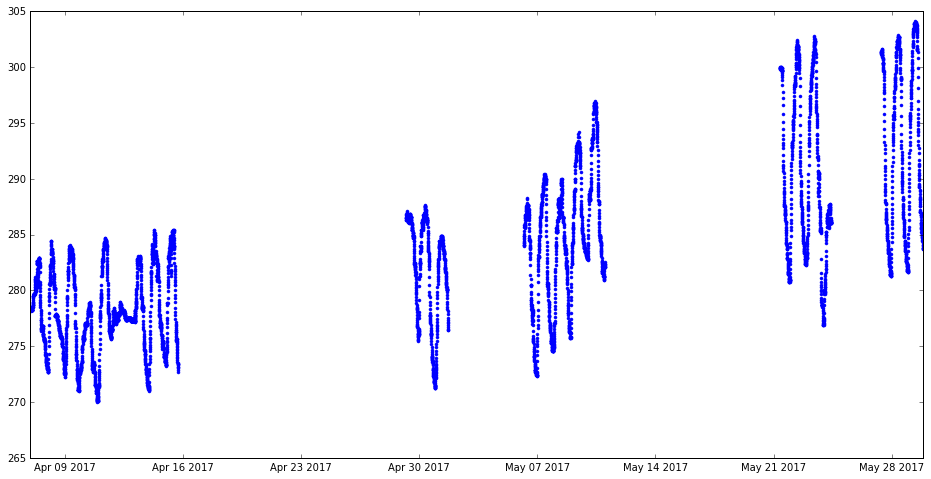

In [411]:
# for weather data
file = open("temp_data_all.out","r")
date_temp = np.loadtxt('temp_data_all.out')
file.close()

date_weather_data = date_temp[0]
temp_weather_data = date_temp[1]

time_need_all = np.array([(datetime.datetime.fromtimestamp(x)) + datetime.timedelta(hours=-7)  for x in date_weather_data ])
plt.plot(time_need_all,temp_weather_data+273,'.')

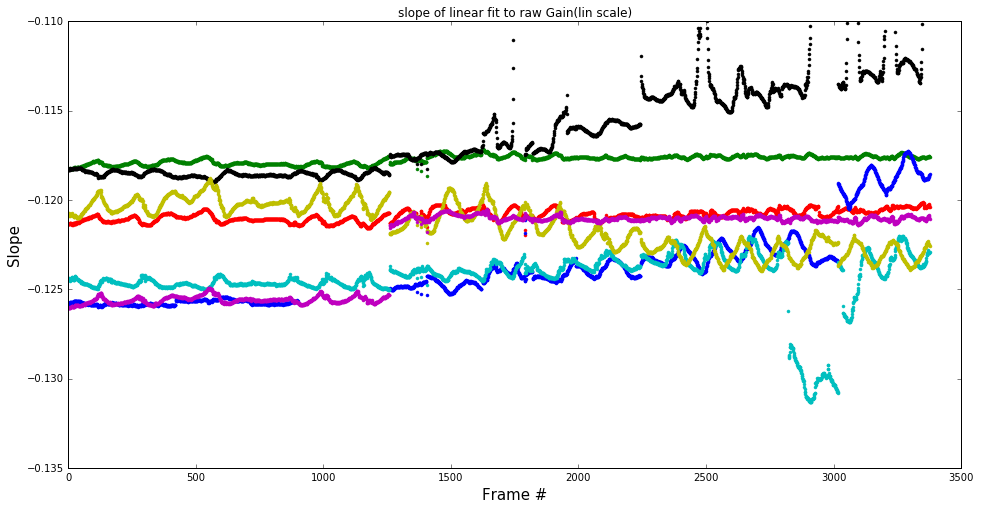

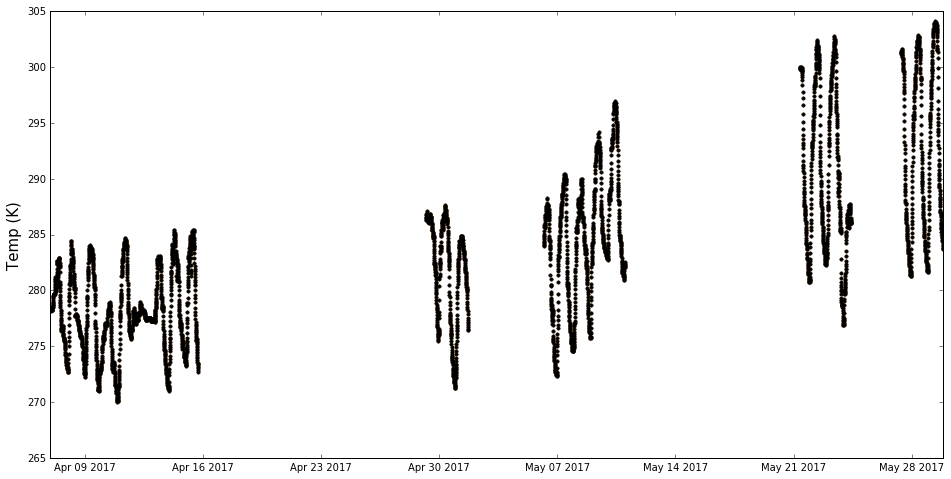

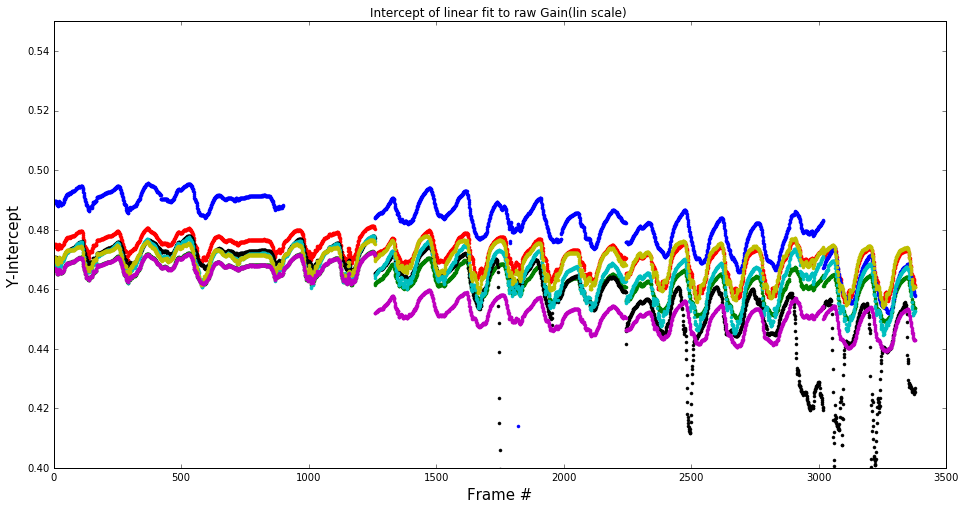

In [440]:
for i in range(len(corr_list)):
    slope_all =np.zeros(len(gain_all[:,1,freq]))
    intercept_all =np.zeros(len(gain_all[:,1,freq]))
    
    for j in range(len(gain_all[:,1,freq])):
        slope,intercept=np.polyfit(freq_phase[50:990], gain_all[j,i,:],1)
        slope_all[j] = slope
        intercept_all[j] = intercept
        
    plt.figure(1)
    plt.title('slope of linear fit to raw Gain(lin scale)')
    plt.xlabel('Frame #', size=15)
    plt.ylabel('Slope', size=15)
    plt.plot(400*slope_all, '.', color=colors[i])
    plt.ylim(-0.135,-0.11)
    
    plt.figure(2)
    plt.plot(time_need_all,temp_weather_data+273,'.')
    plt.ylabel('Temp (K)', size=15)
    
    plt.figure(3)
    plt.title('Intercept of linear fit to raw Gain(lin scale) ')
    plt.plot(intercept_all, '.', color=colors[i])
    plt.ylim(0.4,0.55)
    plt.xlabel('Frame #', size=15)
    plt.ylabel('Y-Intercept', size=15)


    
    #plt.figure(3+i)
    #plt.plot( intercept_all, '.', color=colors[i])
    #plt.plot(gain_all[:,i,freq])

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


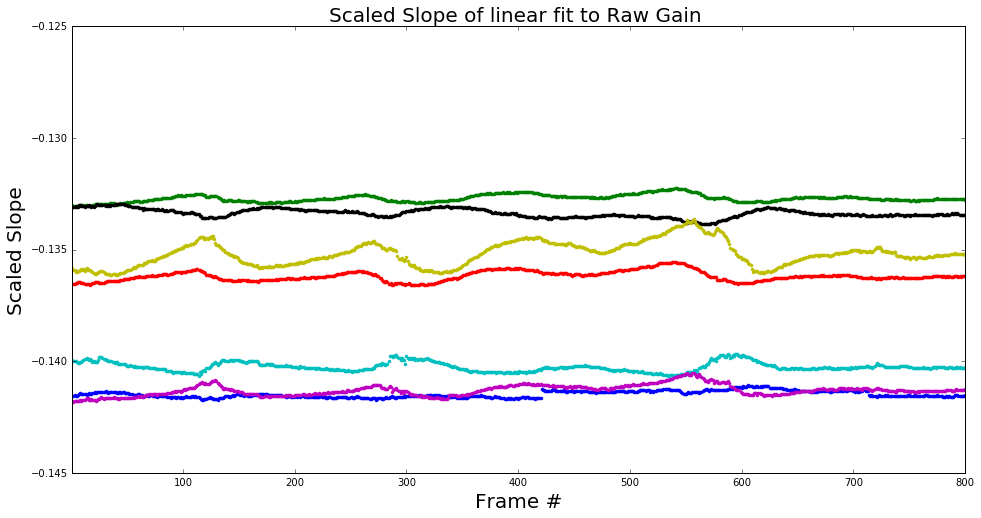

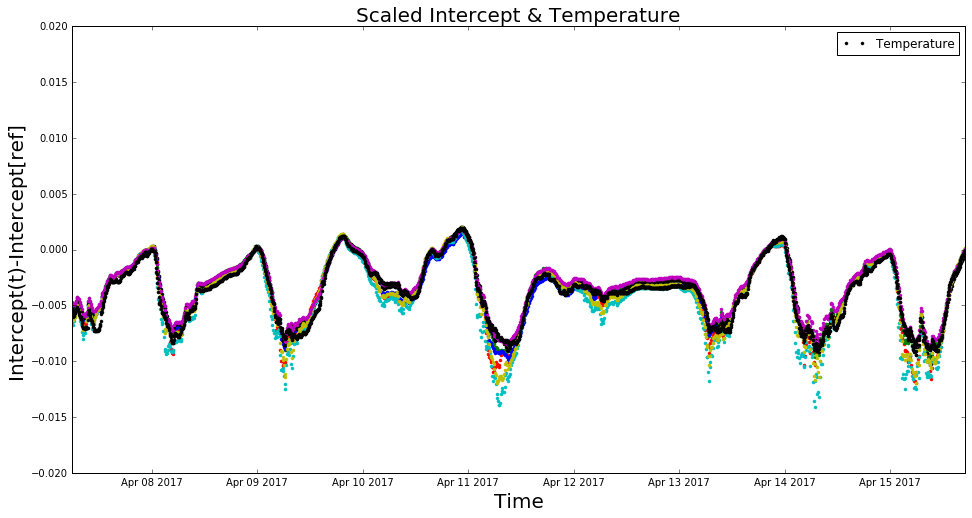

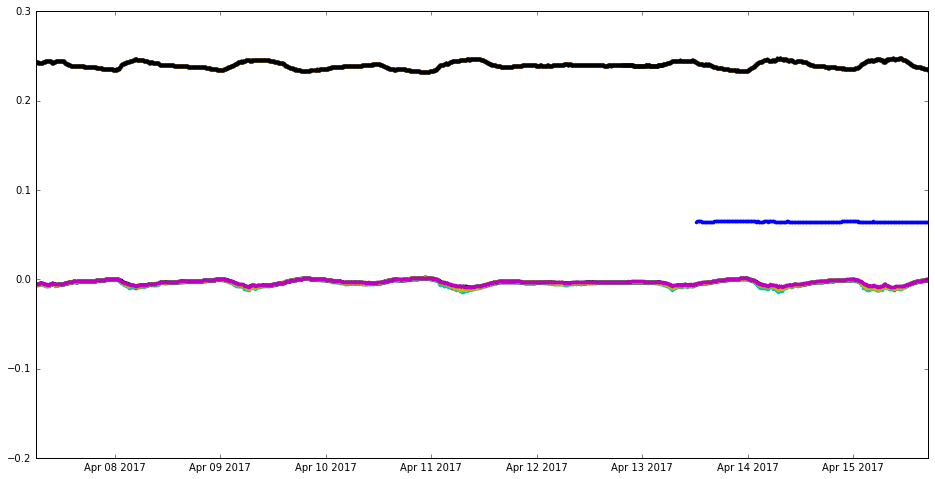

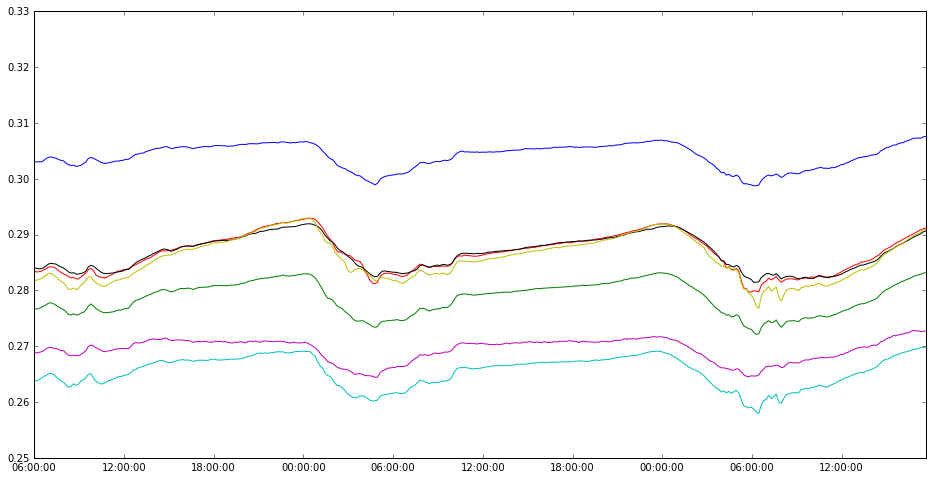

In [756]:
size=len(gain_all[:,1,freq])#1250#421
ref=100
weather_data_size = len(temp_weather_data)#2514#840

for i in range(len(corr_list)):
    slope_all =np.zeros(len(gain_all[0:size,1,freq]))
    intercept_all =np.zeros(len(gain_all[:,1,freq]))
    
    for j in range(len(gain_all[:,1,freq])):
        slope,intercept=np.polyfit(freq_phase[50:990]-freq_phase[500], gain_all[j,i,:],1)
        slope_all[j] = slope
        intercept_all[j] = intercept
        
    temp_partial = temp_weather_data#[0:weather_data_size]
    time_partial = time_need_all#[0:weather_data_size]
    plt.figure(1)
    plt.title('Scaled Slope of linear fit to Raw Gain ', size =20)
    plt.xlabel('Frame #', size=20)
    plt.ylabel('Scaled Slope', size=20)
    plt.plot(450*slope_all, '.', color=colors[i])
    plt.ylim(-0.145,-0.125)
    plt.xlim(1,800)
    
    temp_part_partial = temp_partial[::2]

    plt.figure(2)
    plt.title('Scaled Intercept & Temperature', size =20)
    plt.plot( date_stamp, intercept_all-intercept_all[ref] , '.', color=colors[i])
    plt.xlabel('Time', size=20)
    plt.ylabel('Intercept(t)-Intercept[ref]', size=20)
    if i==6:
        plt.plot(time_need_all,-temp_weather_data/1400-.0002, '.k', label = 'Temperature')
    plt.legend()
    #plt.plot(time_need_all,(-temp_part_partial[50::]/1000), '.')
    #plt.axvline(x = 420)
    #plt.axvline(x = 420+479)
    #plt.axvline(x = 420+479+360)
    #plt.axvline(x = 420+479+84)
    plt.ylim(-0.02,0.02)
    plt.xlim(date_stamp[0],time_need_all[2633])
    
    plt.figure(3)

    plt.plot(date_stamp, intercept_all-intercept_all[ref], '.', color=colors[i])
    plt.plot(time_need_all,(temp_weather_data+235)/1000, '.')
    plt.xlim(date_stamp[0],time_need_all[2633])
    #plt.ylim(-0.02,0.02)
    

    plt.figure(4)
    plt.plot(time_need_all,(temp_weather_data+234)/500, '-')
    plt.plot(date_stamp,gain_all[:,i,freq], color=colors[i])
    plt.xlim(date_stamp[0],time_need_all[800])
    plt.ylim(0.25,0.33)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


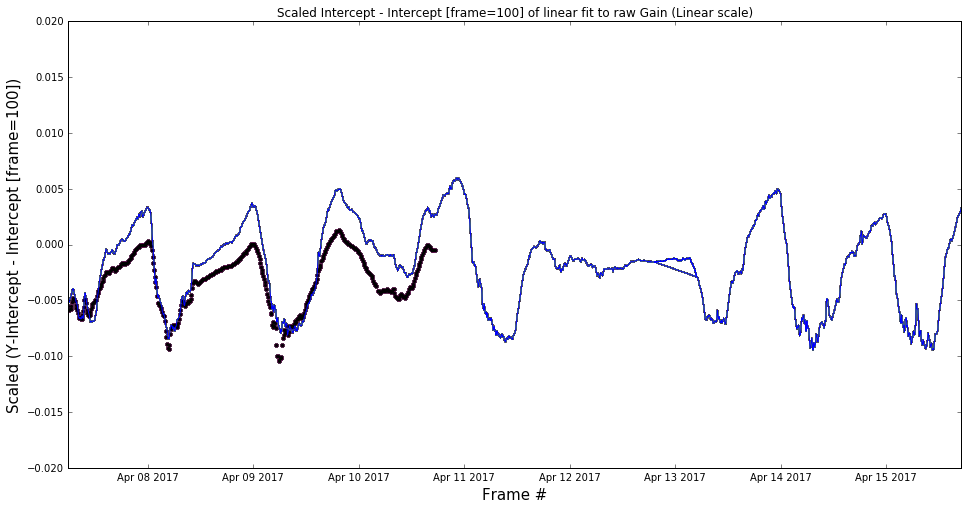

In [455]:
size=len(gain_all[:,1,freq])#1250#421
ref=100
weather_data_size = len(temp_weather_data)#2514#840
i=0
for k in range(200):
    print(k)
    slope_all =np.zeros(len(gain_all[0:size,1,freq]))
    intercept_all =np.zeros(len(gain_all[:,1,freq]))

    for j in range(500):
        
        slope,intercept=np.polyfit(freq_phase[50:990]-freq_phase[500], gain_all[j,i,:],1)
        slope_all[j] = slope
        intercept_all[j] = intercept

    temp_partial = temp_weather_data #[0:weather_data_size]
    time_partial = time_need_all #[0:weather_data_size]

    temp_part_partial = temp_partial[::2]

    plt.figure(1+i)
    plt.title('Scaled Intercept - Intercept [frame=100] of linear fit to raw Gain (Linear scale)')
    plt.plot( date_stamp, intercept_all-intercept_all[ref] , '.')
    plt.xlabel('Frame #', size=15)
    plt.ylabel('Scaled (Y-Intercept - Intercept [frame=100])', size=15)
    plt.plot(time_need_all,(-temp_weather_data/1000)+0.003)

    plt.ylim(-0.02,0.02)
    plt.xlim(date_stamp[0],time_need_all[2633])



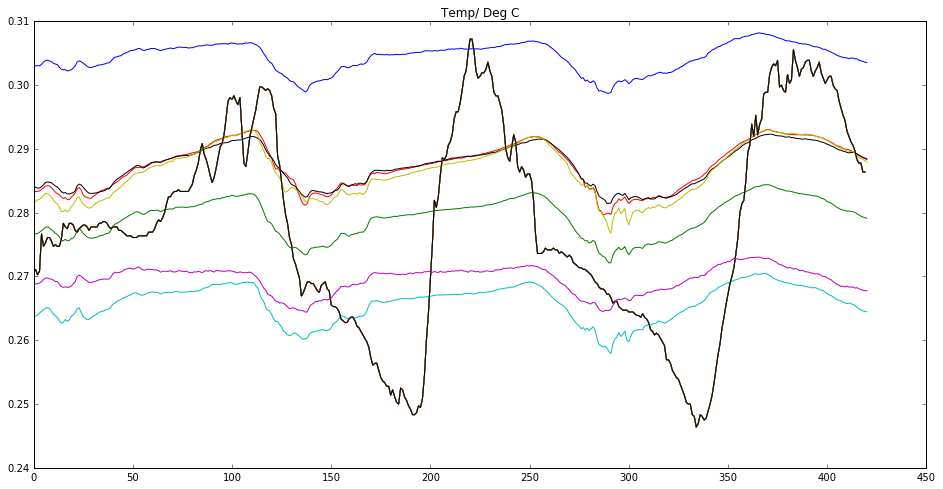

In [376]:
size=421
ref=100
weather_data_size = 840
for i in range(len(corr_list)):
    slope_all =np.zeros(len(gain_all[0:size,1,freq]))
    intercept_all =np.zeros(len(gain_all[0:size,1,freq]))
    
    for j in range(len(gain_all[0:size,1,freq])):
        slope,intercept=np.polyfit(freq_phase[50:990], gain_all[j,i,:],1)
        slope_all[j] = slope
        intercept_all[j] = intercept
        
    temp_partial = temp_weather_data[0:weather_data_size]
    time_partial = time_need_all[0:weather_data_size]

    plt.figure(1)
    plt.plot(time_partial[::2],(temp_partial[::2]/200)+0.25, '-')
    plt.plot(date_stamp[0:size],gain_all[0:size,i,freq], color=colors[i])
    plt.title('Temp/ Deg C')
    
    plt.figure(1)
    plt.plot((temp_partial[::2]/200)+0.25, '-')
    plt.plot(gain_all[0:size,i,freq], color=colors[i])
    plt.title('Temp/ Deg C')


In [419]:
for i in range(len(frame_per_dir)):
    print((frame_per_dir[i]))


print((date_stamp[0]))
print((date_stamp[420]))
print('')
print((date_stamp[421]))
print((date_stamp[899]))
print('')
print((date_stamp[900]))
print((date_stamp[1259]))
print('')
print((date_stamp[1260]))
print((date_stamp[2243]))
print('')
print((date_stamp[2244]))
print((date_stamp[3017]))
print('')
print((date_stamp[3018]))
print((date_stamp[3377]))

421
479
360
984
774
360
2017-04-07 05:57:21
2017-04-10 03:57:19

2017-04-10 04:17:58
2017-04-13 11:57:56

2017-04-13 12:19:17
2017-04-16 00:09:15

2017-04-29 11:17:53
2017-05-11 07:07:45

2017-05-19 08:25:44
2017-05-24 17:15:40

2017-05-27 15:50:09
2017-05-30 03:40:07


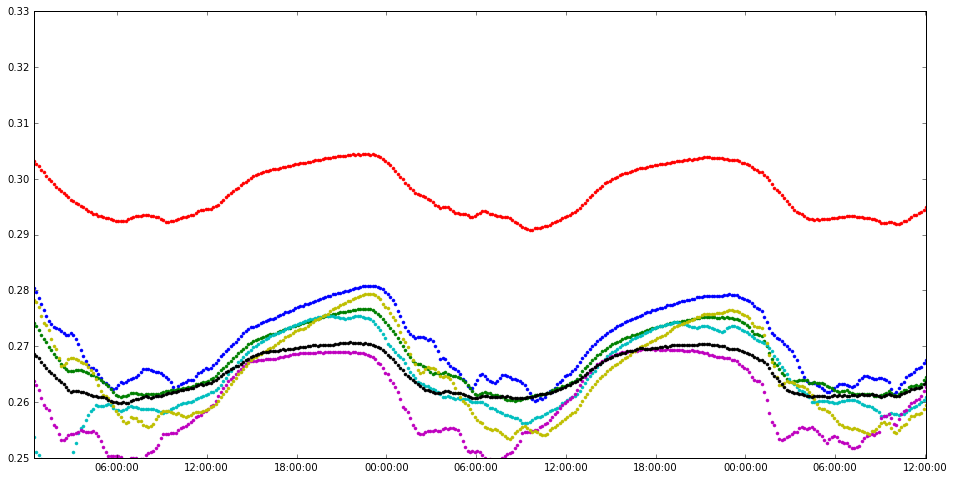

In [518]:
date_stamp_try1 = [datetime.datetime.fromtimestamp(time) for time in time_stamp]
date_stamp_try2 = [datetime.datetime.fromtimestamp(time) + datetime.timedelta(hours = 7) for time in time_stamp] # why not 8
date_stamp = [datetime.datetime.fromtimestamp(time) + datetime.timedelta(hours = -7) for time in time_stamp]
for i in range(len(gain_all[1,:,1])):
    plt.plot(date_stamp,gain_all[:,i,freq],'.')
    plt.ylim(0.25,0.33)
    plt.xlim(date_stamp_try2[2400],date_stamp_try1[2800])

In [525]:
time_stamp_check = get_timestamp(tot_frames,corr_files)

1491595041
1491810440
1491811040
1491847039
1491848278
1492063676
1492064276
1492135076
1492136357
1492351755
1493515073
1493730472
1494163068
1494378467
1494379067
1494536865
1495232744
1495448142
1495448742
1495664140
1495664740
1495696540
1495950609
1496166007


In [549]:
dd = [1491595041,1491810440,1491811040,1491847039,1491848278,1492063676,1492064276,1492135076,1492136357,1492351755,1493515073,1493730472,1494163068,1494378467,1494379067,1494536865,1495232744,1495448142,1495448742,1495664140,1495664740,1495696540,1495950609,1496166007]
date_stamp_try1 = [datetime.datetime.fromtimestamp(time)+datetime.timedelta(hours = -7) for time in dd]

day_all_try = np.zeros(len(date_stamp_try1))
month_all_try = np.zeros(len(date_stamp_try1))
hour_all_try = np.zeros(len(date_stamp_try1))
minute_all_try = np.zeros(len(date_stamp_try1))

for i in range(len(date_stamp_try1)):
    print(date_stamp_try1[i])
    day_all_try[i]=date_stamp_try1[i].day
    month_all_try[i] = np.int(date_stamp_try1[i].month)
    hour_all_try[i] = date_stamp_try1[i].hour
    minute_all_try[i] = date_stamp_try1[i].minute
    
print((np.array(month_all_try)))
print((day_all_try))
print(hour_all_try)
print(minute_all_try)

2017-04-07 05:57:21
2017-04-09 17:47:20
2017-04-09 17:57:20
2017-04-10 03:57:19
2017-04-10 04:17:58
2017-04-12 16:07:56
2017-04-12 16:17:56
2017-04-13 11:57:56
2017-04-13 12:19:17
2017-04-16 00:09:15
2017-04-29 11:17:53
2017-05-01 23:07:52
2017-05-06 23:17:48
2017-05-09 11:07:47
2017-05-09 11:17:47
2017-05-11 07:07:45
2017-05-19 08:25:44
2017-05-21 20:15:42
2017-05-21 20:25:42
2017-05-24 08:15:40
2017-05-24 08:25:40
2017-05-24 17:15:40
2017-05-27 15:50:09
2017-05-30 03:40:07
[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  5.  5.  5.  5.  5.  5.  5.
  5.  5.  5.  5.  5.  5.]
[  7.   9.   9.  10.  10.  12.  12.  13.  13.  16.  29.   1.   6.   9.   9.
  11.  19.  21.  21.  24.  24.  24.  27.  30.]
[  5.  17.  17.   3.   4.  16.  16.  11.  12.   0.  11.  23.  23.  11.  11.
   7.   8.  20.  20.   8.   8.  17.  15.   3.]
[ 57.  47.  57.  57.  17.   7.  17.  57.  19.   9.  17.   7.  17.   7.  17.
   7.  25.  15.  25.  15.  25.  15.  50.  40.]


In [582]:
file = open("temp_data_all.out","r")
date_temp = np.loadtxt('temp_data_all.out')
file.close()

date_weather_data_new = date_temp[0]
temp_weather_data_new = date_temp[1]

temp_frame = [718,120,718,236,718,718,718,526,50,718,106,718]

a= date_weather_data_new[0:718]
b= temp_weather_data_new[0:718]
temp_1 = np.append(a[::2],a[717])
time_1 = np.append(b[::2],b[717])

a= date_weather_data_new[718:838]
b= temp_weather_data_new[718:838]
temp_1 = np.append(temp_1,a[::2])
temp_1 = np.append(temp_1,a[119])
time_1 = np.append(time_1,b[::2])
time_1 = np.append(time_1,b[119])

a= date_weather_data_new[838:1556]
b= temp_weather_data_new[838:1556]
temp_1 = np.append(temp_1,a[::2])
temp_1 = np.append(temp_1,a[717])
time_1 = np.append(time_1,b[::2])
time_1 = np.append(time_1,b[717])

a= date_weather_data_new[1556:1792]
b= temp_weather_data_new[1556:1792]
temp_1 = np.append(temp_1,a[::2])
temp_1 = np.append(temp_1,a[235])
time_1 = np.append(time_1,b[::2])
time_1 = np.append(time_1,b[235])

a= date_weather_data_new[1792:2510]
b= temp_weather_data_new[1792:2510]
temp_1 = np.append(temp_1,a[::2])
temp_1 = np.append(temp_1,a[717])
time_1 = np.append(time_1,b[::2])
time_1 = np.append(time_1,b[717])

a= date_weather_data_new[2510:3228]
b= temp_weather_data_new[2510:3228]
temp_1 = np.append(temp_1,a[::2])
temp_1 = np.append(temp_1,a[717])
time_1 = np.append(time_1,b[::2])
time_1 = np.append(time_1,b[717])

a= date_weather_data_new[3228:3946]
b= temp_weather_data_new[3228:3946]
temp_1 = np.append(temp_1,a[::2])
temp_1 = np.append(temp_1,a[717])
time_1 = np.append(time_1,b[::2])
time_1 = np.append(time_1,b[717])

a= date_weather_data_new[3946:4472]
print(len(a))
b= temp_weather_data_new[3946:4472]
temp_1 = np.append(temp_1,a[::2])
temp_1 = np.append(temp_1,a[525])
time_1 = np.append(time_1,b[::2])
time_1 = np.append(time_1,b[525])

time_partial_new = np.array([(datetime.datetime.fromtimestamp(x)) + datetime.timedelta(hours=-7)  for x in temp_1 ])


526
2244
[ 5.55555556  5.44443778  5.44443778 ...,  9.27777611  9.33332667
  9.55555389]


# Basic model: Just temperature multiplied by some constant

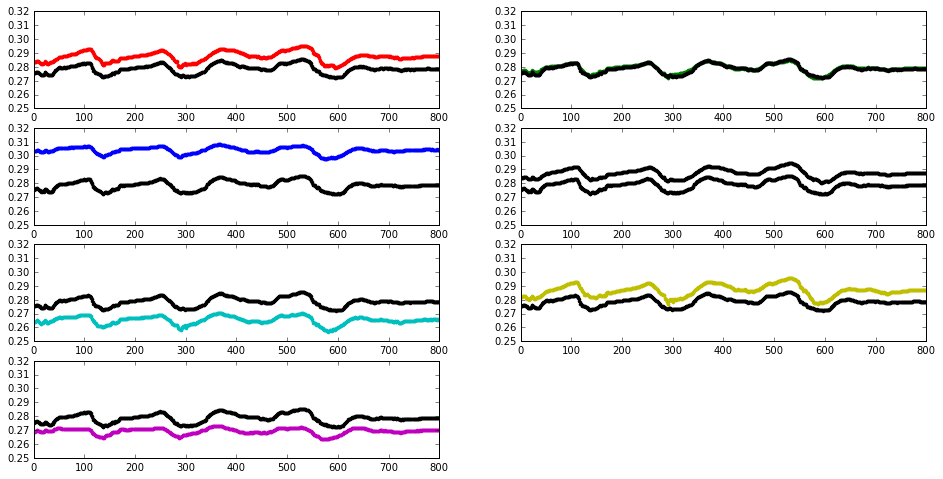

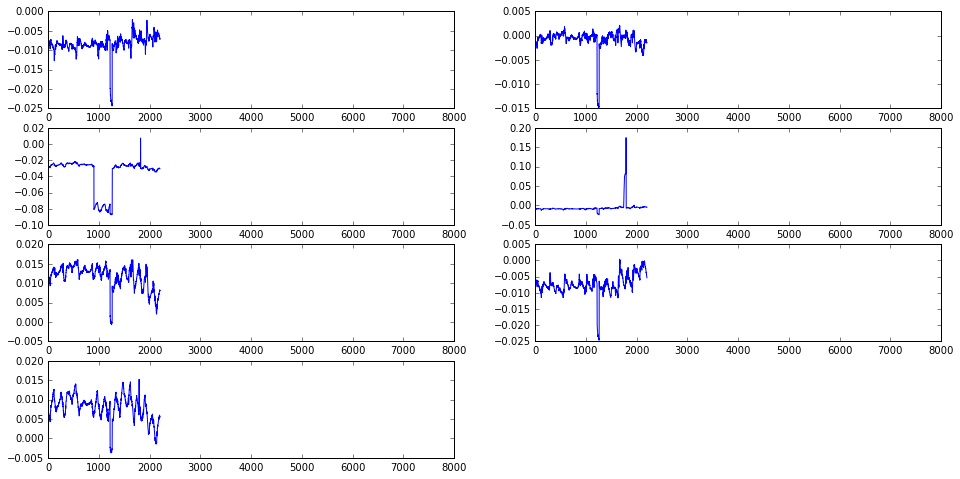

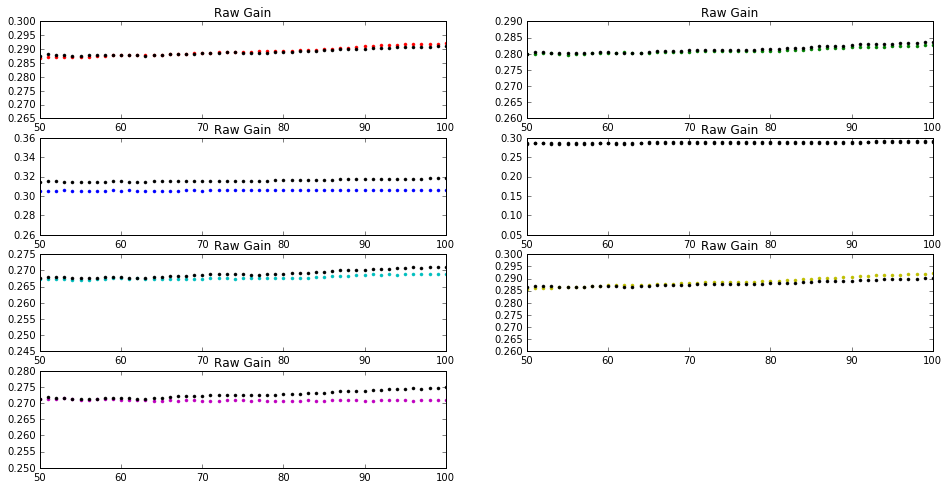

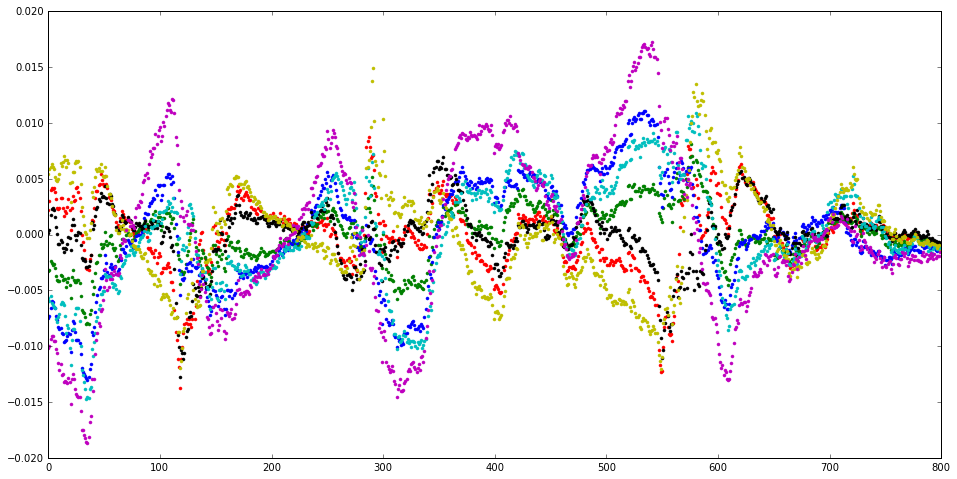

In [711]:

for i in range(len(corr_list)):
    plt.figure(1)
    plt.subplot(4,2,i+1)
    plt.plot(gain_all[0:2243,i,freq],'.', color = colors[i])
    plt.plot(-(time_1[42::]+273)/1100+0.531,'.k')
    plt.ylim(0.25,0.32)
    plt.xlim(0,800)

    plt.figure(2)
    plt.subplot(4,2,i+1)
    difference = -(time_1[42::]+273)/1100+0.531-(gain_all[0:2243-41,i,freq])
    plt.plot(difference)
    dd= np.mean(difference)
    plt.xlim(0,800)
    #plt.ylim(-0.01,0.01)
    
    plt.figure(3)
    plt.subplot(4,2,i+1)
    plt.title('Raw Gain')
    plt.plot(gain_all[0:2243,i,freq],'.', color = colors[i])
    plt.plot(-(time_1[42::]+273)/1100+0.531 -dd,'.k')
    plt.xlim(50,100)
    
    plt.figure(4)
    gain_temp_model = -(time_1[42::]+273)/1100+0.531-dd
    gain_frac_temp_model = (gain_temp_model[0:800]-np.mean(gain_temp_model[0:800]))/np.mean(gain_temp_model[0:800])
    gain_frac = (gain_all[0:800,i,freq]-np.mean(gain_all[0:800,i,freq]))/np.mean(gain_all[0:800,i,freq])

    plt.plot(gain_frac_temp_model-gain_frac, '.',color =colors[i])
    #plt.ylim(-0.01,0.01)

C:\Users\sidhant\Anaconda3\envs\py3k\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


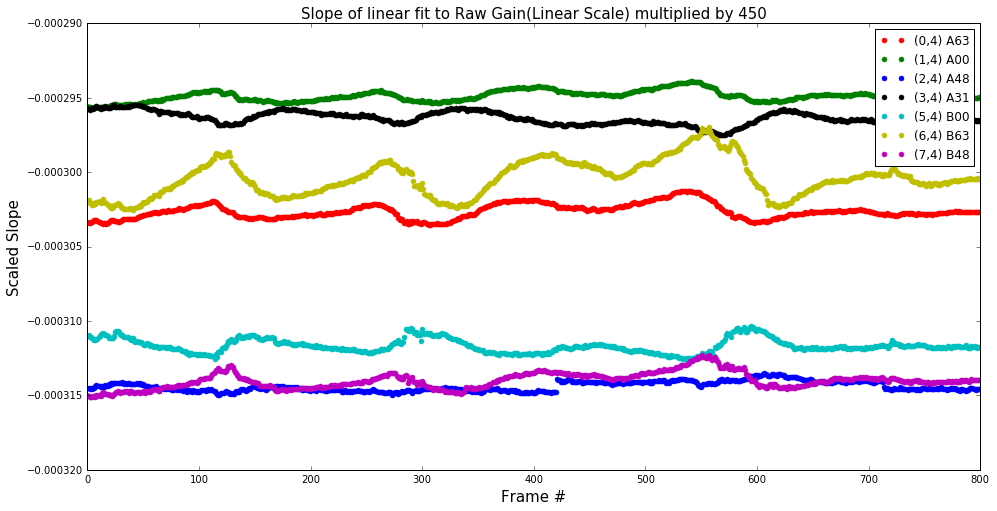

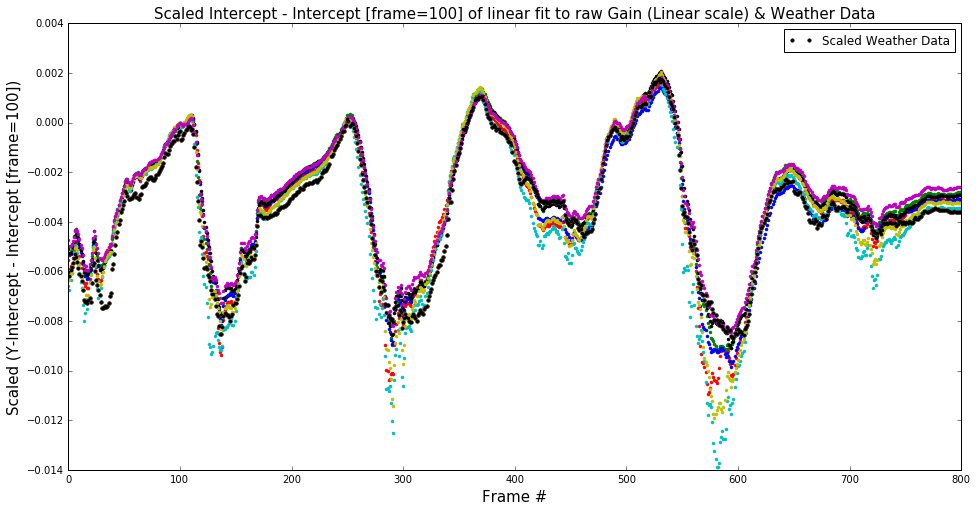

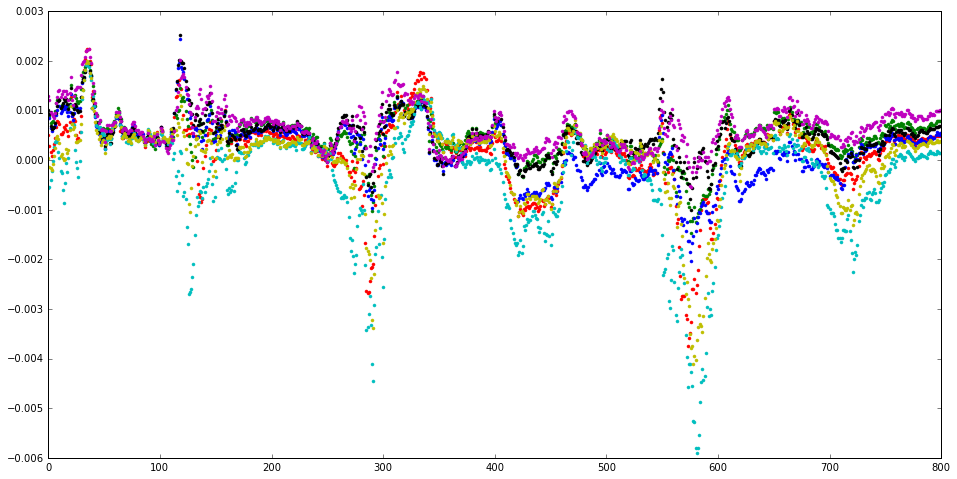

In [741]:
size=800 #len(gain_all[:,1,freq])#1250#421
ref=100
weather_data_size = len(temp_weather_data)#2514#840
temp_intercept_model = time_1[42::]

for i in range(len(corr_list)):
    slope_all =np.zeros(len(gain_all[0:size,1,freq]))
    intercept_all =np.zeros(len(gain_all[0:size,1,freq]))
    
    for j in range(size):
        slope,intercept=np.polyfit(freq_phase[50:990]-freq_phase[freq], gain_all[j,i,:],1)
        slope_all[j] = slope
        intercept_all[j] = intercept
        
    temp_par_yint_mod = temp_intercept_model[0:800]+273
    
    plt.figure(1)
    plt.title('Slope of linear fit to Raw Gain(Linear Scale) multiplied by 450', size=15)
    plt.xlabel('Frame #', size=15)
    plt.ylabel('Scaled Slope', size=15)
    plt.plot(slope_all, '.', markersize =10, color=colors[i], label = legend_crosscorr[i])
    #plt.ylim(-0.145,-0.125)
    plt.legend()
    
    plt.figure(2)
    if i==1: 
        plt.plot(-(temp_intercept_model[0:size]+235)/1400 +0.235-0.019-0.0205-0.015-0.013,'.k',markersize=7, label ='Scaled Weather Data')

        
    plt.title('Scaled Intercept - Intercept [frame=100] of linear fit to raw Gain (Linear scale) & Weather Data', size=15)
    plt.plot(intercept_all-intercept_all[ref], '.', color=colors[i])
    plt.plot(-(temp_intercept_model[0:size]+235)/1400 +0.235-0.019-0.0205-0.015-0.013,'.')
    plt.xlabel('Frame #', size=15)
    plt.ylabel('Scaled (Y-Intercept - Intercept [frame=100])', size=15)
    plt.legend()
    #plt.plot(-temp_weather_data/1400-.001, '.')

    plt.figure(3)
    plt.plot((intercept_all-intercept_all[ref])-(-(temp_intercept_model[0:size]+235)/1400 +0.235-0.019-0.0205-0.015-0.013), '.', color=colors[i])
    #plt.ylim(-5,5)
    #plt.plot(time_need_all,(-temp_part_partial[50::]/1000), '.')
    #plt.axvline(x = 420)
    #plt.axvline(x = 420+479)
    #plt.axvline(x = 420+479+360)
    #plt.axvline(x = 420+479+84)
    #plt.ylim(-0.02,0.02)
    #plt.xlim(date_stamp[0],time_need_all[2633])
    '''
    plt.figure(3)
    plt.plot(time_need_all,(temp_weather_data+235)/1000, '.')
    plt.plot(date_stamp, intercept_all-intercept_all[ref], '.', color=colors[i])
    plt.xlim(date_stamp[0],time_need_all[2633])
    plt.ylim(-0.02,0.02)
    

    plt.figure(4)
    plt.plot(time_need_all,(temp_weather_data+234)/500, '-')
    plt.plot(date_stamp,gain_all[:,i,freq], color=colors[i])
    plt.xlim(date_stamp[0],time_need_all[800])
    plt.ylim(0.25,0.33)
    '''